In [3]:
import os
import sys
import gc
import math
import json
from pathlib import Path
from glob import glob
import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2                     
from skimage import exposure    # for CLAHE & image utilities
from skimage import measure     # regionprops
from skimage.morphology import skeletonize, remove_small_objects, binary_closing, disk

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, confusion_matrix

## 1. **Dataset Introduction**

The project utilizes the **RSNA Bone Age Dataset**, a rich collection of hand X-ray images paired with clinical metadata. The primary objective is to estimate a patient's bone age — a continuous value measured in months — from a single radiograph. Bone-age estimation is crucial for assessing skeletal maturity, diagnosing growth disorders, and identifying endocrine abnormalities in pediatric healthcare.

### **Core Task Definitions**

#### **a. Regression Problem**

Mapping an input image to a continuous bone-age value:

\[
f: \text{Image} \rightarrow \text{Age (in years)}
\]

#### **b. Classification Problem**

Categorizing bone age into discrete developmental stages (e.g., Child, Adolescent, Adult).  
In this work, bone age is divided into **10 uniform age bins**, creating a multi-class classification task.

### **Metadata Description**

The dataset metadata is provided through a CSV file containing:

- **id** — Unique identifier for mapping each image file  
- **boneage** — Ground-truth bone age (in months)  
- **male** (or **sex**) — Biological sex of the patient, encoded as a binary feature  


In [4]:
dataframe_direction = '/kaggle/input/rsna-bone-age'
training_dataframe = pd.read_csv("/kaggle/input/rsna-bone-age/boneage-training-dataset.csv")

#creating a path for images
training_dataframe['path'] = training_dataframe['id'].map(lambda x: os.path.join(dataframe_direction,'boneage-training-dataset','boneage-training-dataset','{}.png'.format(x)))

training_dataframe['imagepath'] = training_dataframe['id'].map(lambda x: '{}.png'.format(x))
training_dataframe['gender'] = training_dataframe['male'].map(lambda x: 'male' if x else 'female')
training_dataframe['sex'] = training_dataframe['gender'].map(lambda x: 1 if x=='male' else 0) # Sex=1 means male,  and Sex=0  means female
training_dataframe['boneage_category'] = pd.cut(training_dataframe['boneage'], 10)
#Calculation of some statistical concepts
boneage_std = 2 * training_dataframe['boneage'].std()
boneage_mean = training_dataframe['boneage'].mean()
training_dataframe['norm_age'] = (training_dataframe['boneage'] - boneage_mean)/boneage_std


training_dataframe.head(5)

id  boneage   male                                               path  \
0  1377      180  False  /kaggle/input/rsna-bone-age/boneage-training-d...   
1  1378       12  False  /kaggle/input/rsna-bone-age/boneage-training-d...   
2  1379       94  False  /kaggle/input/rsna-bone-age/boneage-training-d...   
3  1380      120   True  /kaggle/input/rsna-bone-age/boneage-training-d...   
4  1381       82  False  /kaggle/input/rsna-bone-age/boneage-training-d...   

  imagepath  gender  sex boneage_category  norm_age  
0  1377.png  female    0   (159.9, 182.6]  0.639590  
1  1378.png  female    0    (0.773, 23.7] -1.400135  
2  1379.png  female    0    (91.8, 114.5] -0.404555  
3  1380.png    male    1   (114.5, 137.2] -0.088883  
4  1381.png  female    0     (69.1, 91.8] -0.550249

In [5]:
dataframe_direction = '/kaggle/input/rsna-bone-age'
testing_Dataframe = pd.read_csv("/kaggle/input/rsna-bone-age/boneage-test-dataset.csv")

#creating a path for images
testing_Dataframe['path'] = testing_Dataframe['Case ID'].map(lambda x: os.path.join(dataframe_direction,'boneage-test-dataset','boneage-test-dataset','{}.png'.format(x)))
testing_Dataframe['imagepath'] = testing_Dataframe['Case ID'].map(lambda x: '{}.png'.format(x))
testing_Dataframe['gender'] = testing_Dataframe['Sex'].map(lambda x: 'male' if x=='M' else 'female')
testing_Dataframe['sex'] = testing_Dataframe['Sex'].map(lambda x: 1 if x=='M' else 0) # Sex=1 means male,  and Sex=0  means female
testing_Dataframe.head(5)

Case ID Sex                                               path imagepath  \
0     4360   M  /kaggle/input/rsna-bone-age/boneage-test-datas...  4360.png   
1     4361   M  /kaggle/input/rsna-bone-age/boneage-test-datas...  4361.png   
2     4362   M  /kaggle/input/rsna-bone-age/boneage-test-datas...  4362.png   
3     4363   M  /kaggle/input/rsna-bone-age/boneage-test-datas...  4363.png   
4     4364   M  /kaggle/input/rsna-bone-age/boneage-test-datas...  4364.png   

  gender  sex  
0   male    1  
1   male    1  
2   male    1  
3   male    1  
4   male    1

## 2. **Exploratory Data Analysis (EDA) and Inferences**

The initial Exploratory Data Analysis (EDA) aimed to understand the distribution of the target variable **boneage** and examine how it correlates with key metadata attributes such as **sex** and **age group**. This included analyzing:

- Distribution plots of bone age to identify skewness and age concentration  
- Gender-wise bone age distribution to detect demographic variations  
- Relationships between bone age and engineered features such as normalized age or age bins  

These insights guided preprocessing decisions, model architecture choices, and strategies for both regression and classification tasks.

/tmp/ipykernel_47/3858991235.py:62: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



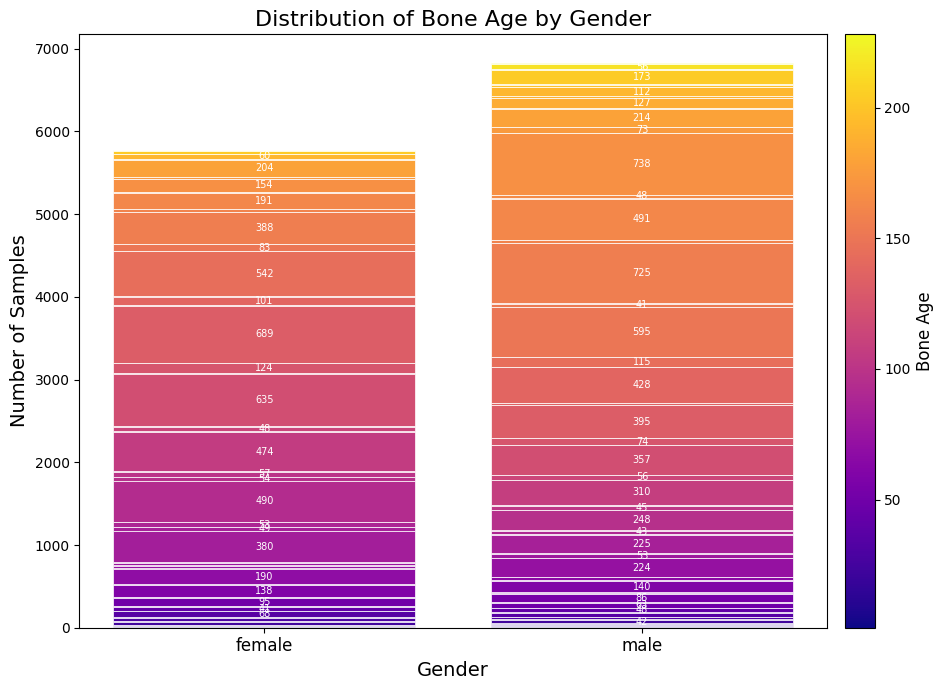

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Prepare grouped data
grouped = training_dataframe.groupby(['gender', 'boneage']).size().reset_index(name='count')

# Pivot: rows = gender, columns = boneage
pivot = grouped.pivot(index='gender', columns='boneage', values='count').fillna(0)

# Sort boneage ascending (important for gradient)
pivot = pivot.reindex(sorted(pivot.columns), axis=1)

# Color map (similar to Plotly plasma)
cmap = plt.cm.plasma
norm = mcolors.Normalize(vmin=pivot.columns.min(), vmax=pivot.columns.max())

plt.figure(figsize=(10, 7))

bottom_heights = np.zeros(len(pivot))

x = np.arange(len(pivot.index))  # [0,1] for female,male

for boneage in pivot.columns:
    heights = pivot[boneage].values
    color = cmap(norm(boneage))

    bars = plt.bar(
        x,
        heights,
        bottom=bottom_heights,
        color=color,
        edgecolor="white",
        linewidth=0.5
    )

    # Add text only if visible (avoid clutter)
    for i, h in enumerate(heights):
        if h > 40:   # threshold to show numbers (adjustable)
            plt.text(
                x[i],
                bottom_heights[i] + h / 2,
                f"{int(h)}",
                ha="center",
                va="center",
                fontsize=7,
                color="white"
            )

    bottom_heights += heights

# Axis labels
plt.xticks(x, pivot.index, fontsize=12)
plt.ylabel("Number of Samples", fontsize=14)
plt.xlabel("Gender", fontsize=14)
plt.title("Distribution of Bone Age by Gender", fontsize=16)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, pad=0.02)
cbar.set_label("Bone Age", fontsize=12)

plt.tight_layout()
plt.show()


The distribution of bone age across genders shows a clear concentration in certain age ranges. Both male and female samples are predominantly clustered between bone ages 50 and 200, indicating a higher representation of children and adolescents in this dataset. Females show slightly higher counts in the middle bone age ranges (around 100–150), while males have higher counts in slightly older ranges (around 150–200). Overall, the dataset is reasonably balanced between genders, but there is a subtle variation in peak bone ages for males and females. This suggests that any predictive model should account for gender-specific patterns in bone development.

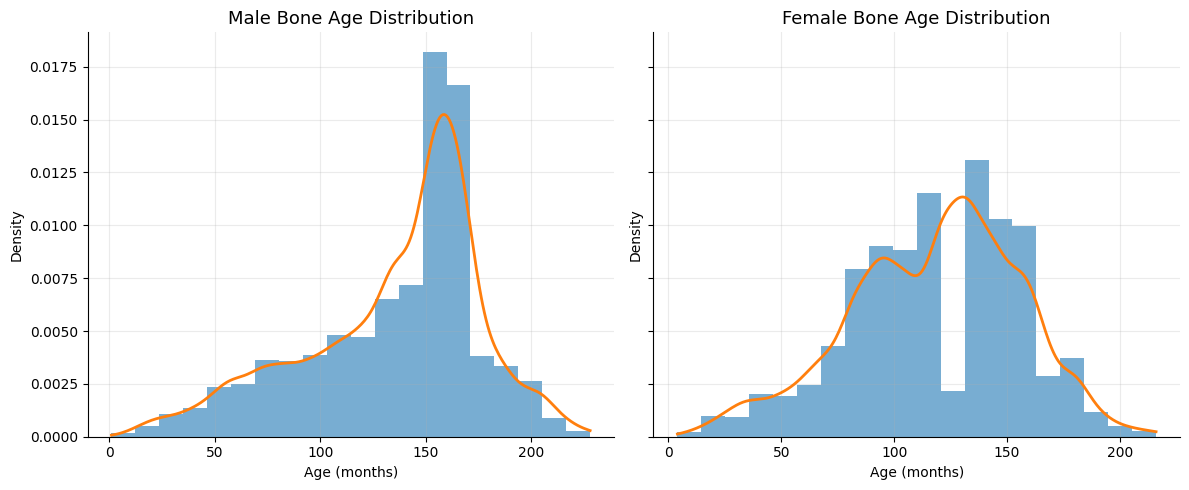

In [20]:
def plot_gender_distribution(df, genders=('male','female'), bins=20):
    # figure layout
    fig, axes = plt.subplots(1, len(genders), figsize=(12,5), sharey=True)
    
    for ax, g in zip(axes, genders):
        subset = df[df['gender'] == g]['boneage']

        # histogram
        ax.hist(subset, bins=bins, density=True, alpha=0.6)

        # smooth density curve
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(subset)
        x_range = np.linspace(subset.min(), subset.max(), 300)
        ax.plot(x_range, kde(x_range), linewidth=2)

        # titles and labels
        ax.set_title(f"{g.capitalize()} Bone Age Distribution", fontsize=13)
        ax.set_xlabel("Age (months)")
        ax.set_ylabel("Density")

        # style
        ax.grid(alpha=0.25)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

# call the function
plot_gender_distribution(training_dataframe)


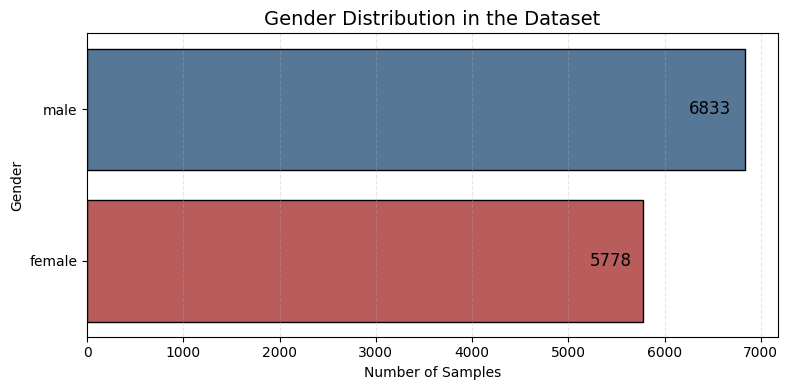

In [62]:
def plot_gender_counts(df):
    # Count values
    counts = df['gender'].value_counts().reset_index()
    counts.columns = ['gender', 'count']

    # figure
    plt.figure(figsize=(8,4))

    sns.barplot(
        data=counts,
        y='gender',
        x='count',
        palette=['#4B79A1', '#C94C4C'],   # different colors for male/female
        edgecolor='black'
    )

    # annotate counts inside bars
    for index, row in counts.iterrows():
        plt.text(
            row['count'] * 0.98,        # near right edge
            index,
            str(row['count']),
            ha='right',
            va='center',
            fontsize=12,
            color='black'
        )

    plt.title("Gender Distribution in the Dataset", fontsize=14)
    plt.xlabel("Number of Samples")
    plt.ylabel("Gender")
    plt.grid(axis='x', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

# call the function
plot_gender_counts(training_dataframe)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



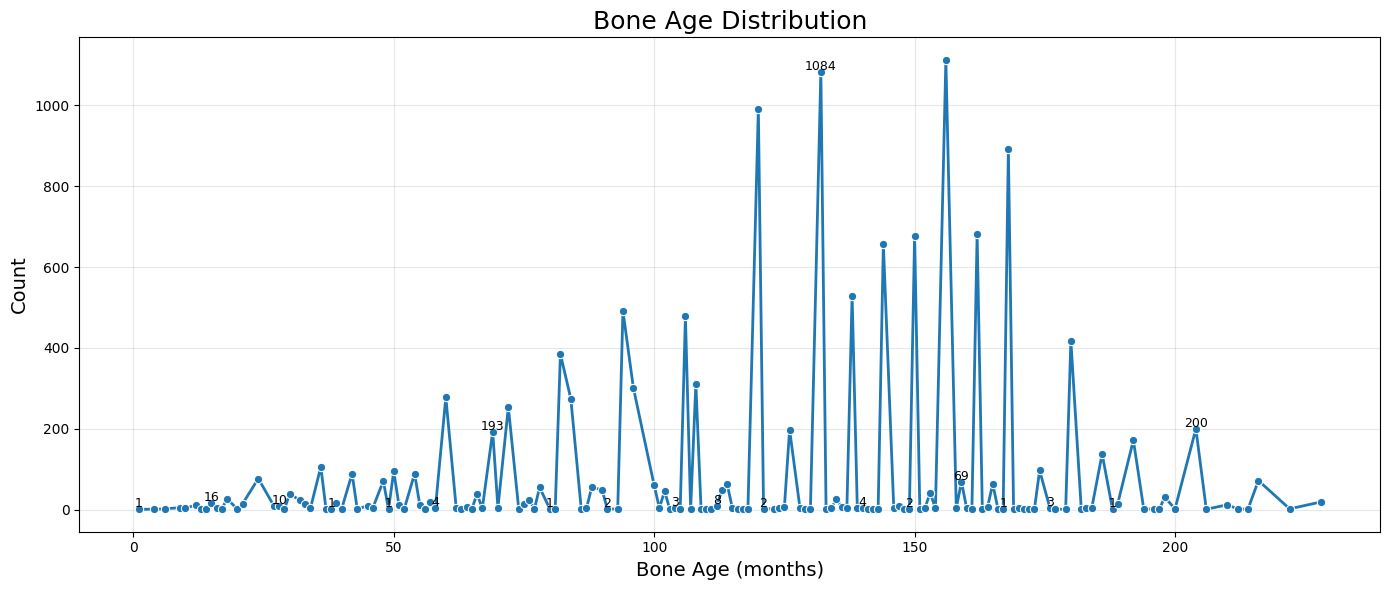

In [63]:
def plot_boneage_frequency(df):
    # group by bone age
    age_counts = df.groupby('boneage')['sex'].count().reset_index()
    age_counts.columns = ['boneage', 'count']

    # sort by boneage (important)
    age_counts = age_counts.sort_values('boneage')

    # figure
    plt.figure(figsize=(14, 6))

    sns.lineplot(
        data=age_counts,
        x='boneage',
        y='count',
        marker='o',
        linewidth=2,
        markersize=6
    )

    # annotate a few key peaks
    for idx in age_counts.index[::8]:  # annotate every 8th point
        x = age_counts.loc[idx, 'boneage']
        y = age_counts.loc[idx, 'count']
        plt.text(x, y + 5, str(y), fontsize=9, ha='center')

    plt.title("Bone Age Distribution", fontsize=18)
    plt.xlabel("Bone Age (months)", fontsize=14)
    plt.ylabel("Count", fontsize=14)

    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# call
plot_boneage_frequency(training_dataframe)

The plot shows that the bone-age distribution in the dataset is highly imbalanced, with very few samples in early childhood (0–50 months) and extremely dense clustering in the pubertal range (100–160 months), where several ages appear hundreds to more than a thousand times. This indicates that the dataset is dominated by mid-adolescent cases, while younger and older ages are underrepresented, which can lead to biased model learning unless addressed through resampling or weighting strategies.

## **EDA Summary Table**

| **EDA Step**            | **Inferred Pattern**                                                                                                                                                             | **Model Helpfulness**                                                                                                                                                                                                     |
|-------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Data Distribution**   | "The dataset is generally balanced in gender, but the age distribution is skewed, with fewer samples at the very young and very old extremes."                                     | The balanced gender split ensured the model did not learn from a dominant class. The skewed age distribution indicated the need for robust regression techniques and stratified splitting to preserve rare age ranges.    |
| **Gender-Age Correlation** | "Males generally have a higher bone age than females for the same chronological age, confirming a known clinical finding."                                                         | This correlation justified integrating gender as an additional feature in the model architecture (Approach 2), transforming the task into multimodal regression.                                                           |
| **Age Normalization**   | "Bone age was normalized by calculating the mean and standard deviation from the training set (norm_age)."                                                                         | Normalization improved training stability and optimizer convergence, allowing the model to learn from a standardized range.                                                                                                |
| **Categorization**      | "The bone age was binned into 10 distinct categories."                                                                                                                             | Binning enabled a multi-class classification setup, supporting the classification task defined in the project.                                                                                                             |


In [6]:
def load_single_image(path):
    """Load a PNG/JPG/DICOM file into a grayscale numpy array."""
    ext = Path(path).suffix.lower()
    
    if ext in [".png", ".jpg", ".jpeg"]:
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        if img is None:
            raise IOError(f"Could not read: {path}")
        if img.ndim == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return img

    elif ext == ".dcm":
        import pydicom
        ds = pydicom.dcmread(path)
        arr = ds.pixel_array.astype(np.float32)
        arr = (arr - arr.min()) / (arr.max() - arr.min() + 1e-6)
        arr = (arr * 255).astype(np.uint8)
        return arr

    else:
        raise ValueError(f"Unsupported format: {ext}")


def show_images_from_folder(
    folder_path, 
    n_samples=9, 
    preprocess_fn=None, 
    title="Image Samples"
):
    """
    Display sample images from a folder.
    """
    image_files = glob(os.path.join(folder_path, "**", "*.*"), recursive=True)
    image_files = [f for f in image_files 
                   if Path(f).suffix.lower() in [".png", ".jpg", ".jpeg", ".dcm"]]

    if len(image_files) == 0:
        raise FileNotFoundError(f"No image files found under: {folder_path}")

    image_files = image_files[:n_samples]

    rows = cols = int(math.ceil(math.sqrt(n_samples)))

    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    fig.suptitle(title, fontsize=16)

    axes = axes.flatten()

    for ax, path in zip(axes, image_files):
        img = load_single_image(path)
        if preprocess_fn is not None:
            img = preprocess_fn(img)

        ax.imshow(img, cmap='gray')
        ax.set_title(Path(path).name, fontsize=8)
        ax.axis('off')

    for ax in axes[len(image_files):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [7]:
BASE_PATH = "/kaggle/input/rsna-bone-age"   
RAW_IMG_PATH = f"{BASE_PATH}/boneage-training-dataset/boneage-training-dataset" 
LABELS_CSV = f"{BASE_PATH}/boneage-training-dataset.csv"


OUT_DIR = "/kaggle/working/data"
ANNOT_DIR = os.path.join(OUT_DIR, "annotate_samples")
BASELINE_MASK_DIR = os.path.join(OUT_DIR, "baseline_masks")

os.makedirs(ANNOT_DIR, exist_ok=True)
os.makedirs(BASELINE_MASK_DIR, exist_ok=True)

In [8]:
df = pd.read_csv(LABELS_CSV)
print("CSV Loaded: ", df.shape)
df.head()

CSV Loaded:  (12611, 3)


id  boneage   male
0  1377      180  False
1  1378       12  False
2  1379       94  False
3  1380      120   True
4  1381       82  False

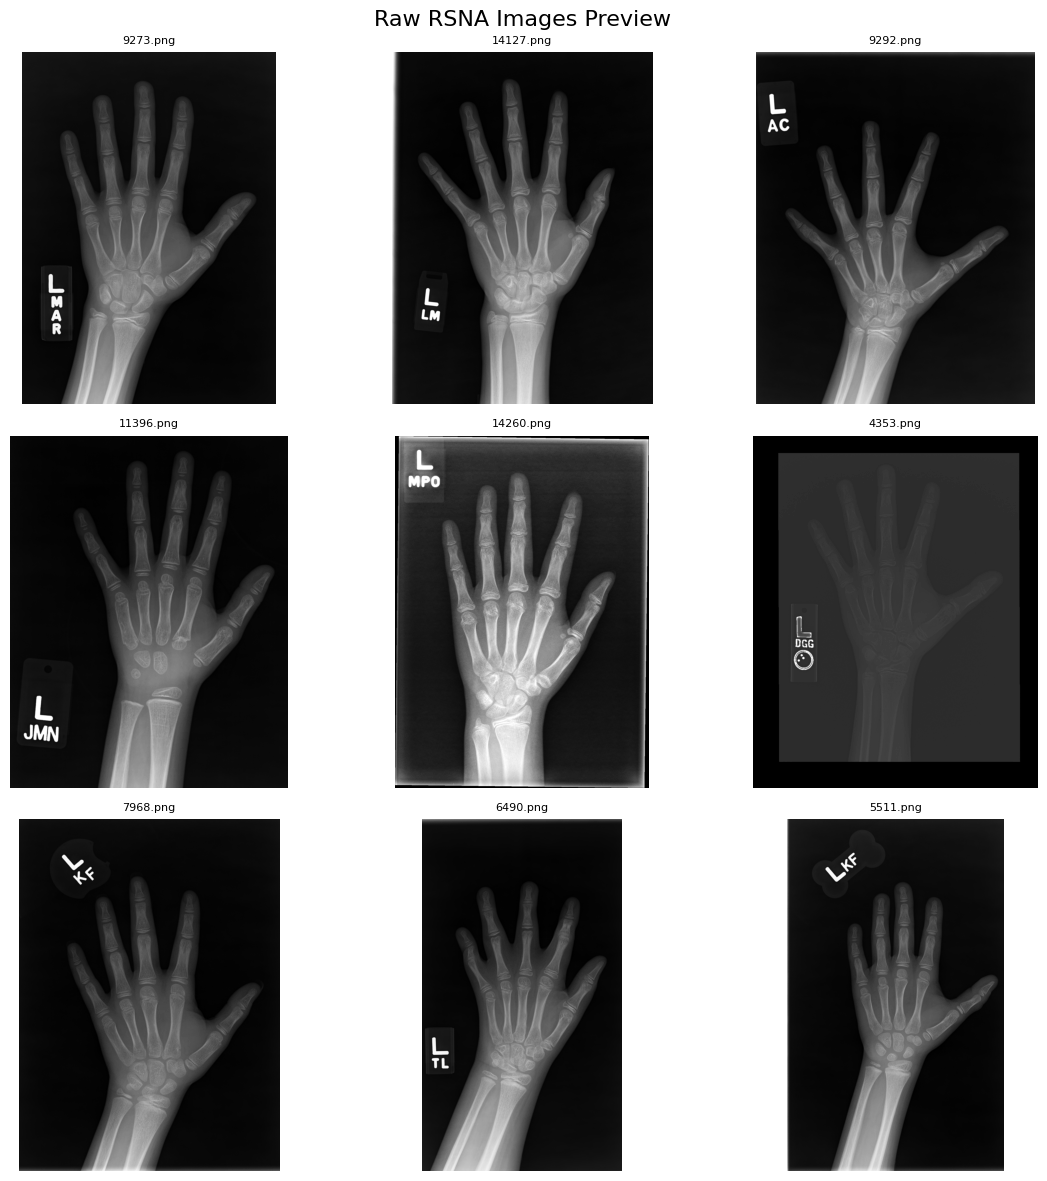

In [9]:
#raw sample images from the given dataset
show_images_from_folder(
    folder_path=RAW_IMG_PATH,
    n_samples=9,
    preprocess_fn=None,
    title="Raw RSNA Images Preview"
)

In [10]:
IMG_TARGET_SIZE = 256      
APPLY_CLAHE = True         
NORMALIZE_0_1 = True        # Normalize to [0, 1]

## **Image Preprocessing Steps**

Before feature extraction, the X-ray images underwent several critical preprocessing operations to ensure consistency, improve visual quality, and enhance downstream model performance:

### **1. Resizing**
All X-ray images were resized to a fixed resolution (e.g., **256 × 256 pixels**) to:
- Maintain a uniform input size for CNN-based feature extractors  
- Prevent spatial bias caused by varying original image dimensions  
- Optimize GPU memory usage and training speed  

### **2. Contrast Enhancement (CLAHE)**
To address low contrast and inconsistent brightness commonly seen in radiographic images, **Contrast Limited Adaptive Histogram Equalization (CLAHE)** was applied.  
CLAHE helps by:
- Enhancing local contrast in bone regions  
- Revealing subtle skeletal structures  
- Preventing noise amplification by applying contrast limits  

These preprocessing steps collectively improved the clarity of anatomical patterns and provided standardized, high-quality inputs for the feature extraction pipeline.


In [11]:
def clahe_enhance(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(img)

def resize_with_padding(img, target=IMG_TARGET_SIZE):
    h, w = img.shape
    scale = target / max(h, w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    pad_top = (target - new_h) // 2
    pad_bottom = target - new_h - pad_top
    pad_left = (target - new_w) // 2
    pad_right = target - new_w - pad_left

    padded = cv2.copyMakeBorder(
        resized, pad_top, pad_bottom, pad_left, pad_right,
        cv2.BORDER_CONSTANT, value=0
    )
    return padded

def preprocess_image(img):
    if APPLY_CLAHE:
        img = clahe_enhance(img)

    img = resize_with_padding(img)

    if NORMALIZE_0_1:
        img = img.astype("float32") / 255.0
    else:
        img = img.astype("float32")

    return img

In [13]:
print("=== Testing preprocessing on dataset (no saving) ===")

all_image_paths = glob(f"{RAW_IMG_PATH}/*.*")
failed = 0

for path in tqdm.tqdm(all_image_paths):
    try:
        img = load_single_image(path)
        proc = preprocess_image(img)
        # Not saving, only testing
    except Exception as e:
        print("Failed:", path, e)
        failed += 1

print(f"Finished. Failed images: {failed}")

=== Testing preprocessing on dataset (no saving) ===


100%|██████████| 12611/12611 [09:31<00:00, 22.05it/s]

Finished. Failed images: 0


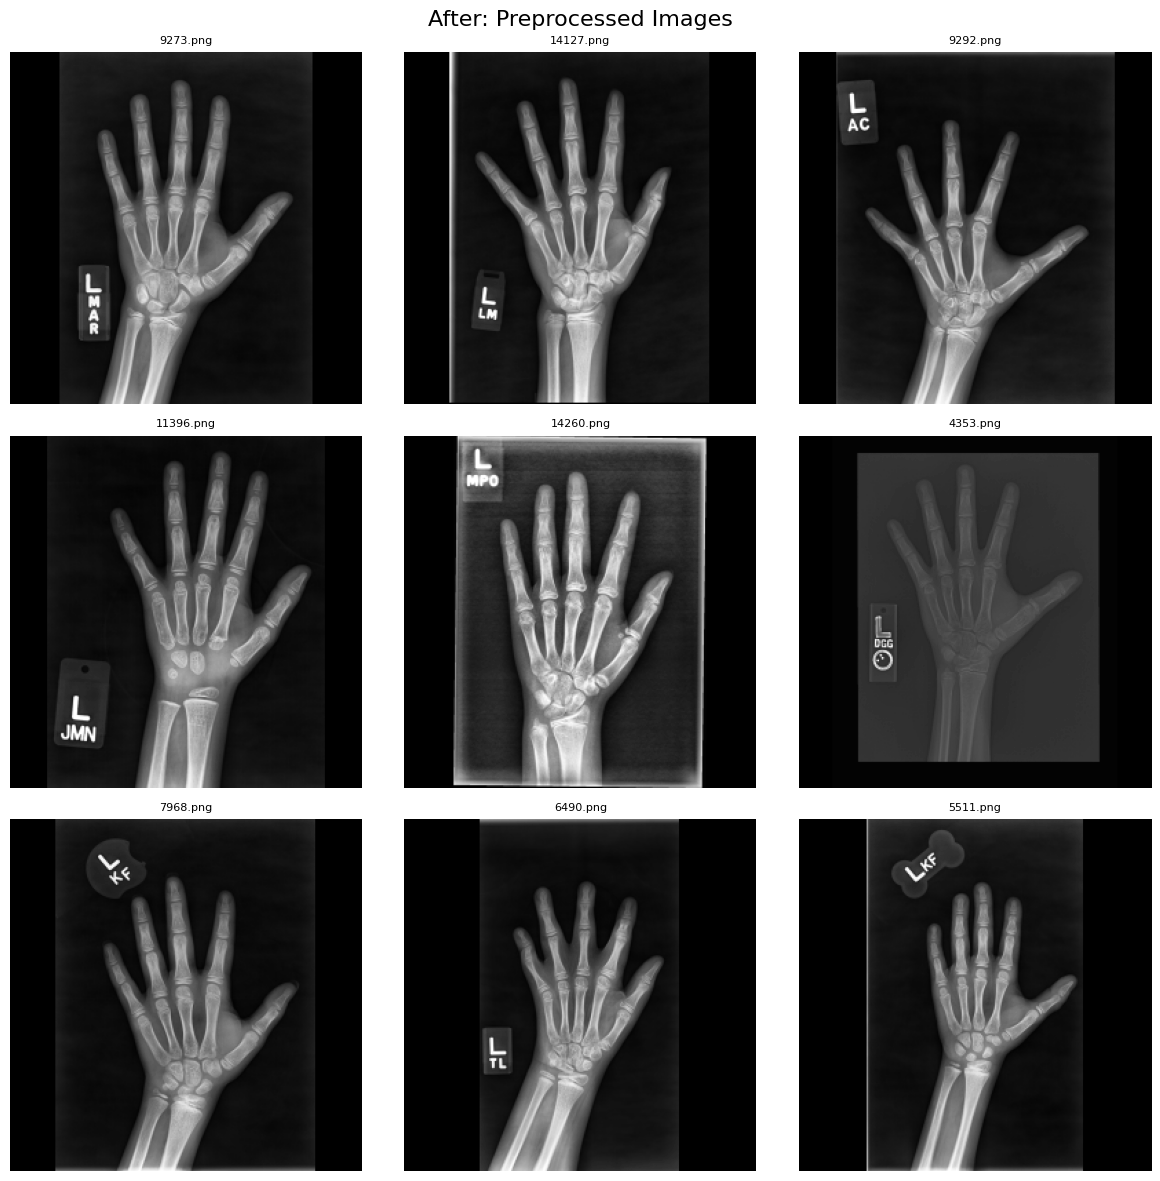

In [14]:
#these processed images improved the clarity of the patterns in the images
show_images_from_folder(RAW_IMG_PATH, n_samples=9, preprocess_fn=preprocess_image, title="After: Preprocessed Images")

## 4. **Segmentation – Different Approaches**

Segmentation was applied to isolate the **region of interest (ROI)** — the hand and wrist bones — from the surrounding background. This step reduces noise, enhances anatomical clarity, and improves the effectiveness of the feature extraction process.

---

### **Approach A: Thresholding and Morphological Operations**

A classical image-processing-based segmentation technique was used to generate a clean binary mask of the hand region.

#### **Method**

- **Adaptive Thresholding:**  
  Automatically separates brighter bone/hand tissue from darker background regions in the X-ray.

- **Morphological Closing (with disk kernels):**  
  Smooths hand contours and fills small gaps within the segmented mask.

- **Hole Filling & Noise Removal:**  
  Removes small isolated components using `remove_small_objects`, ensuring only the hand remains.

#### **Justification**

This approach is:
- **Computationally efficient**
- **Reliable for X-rays** with uniform backgrounds
- Effective in isolating the hand without requiring deep learning–based segmentation models

It serves as a fast, resource-friendly method suitable for preprocessing large medical image datasets.


In [10]:
N_ANNOTATE = 600  

export_paths = all_image_paths[:N_ANNOTATE]

for src in export_paths:
    raw = cv2.imread(src, cv2.IMREAD_GRAYSCALE)
    proc = preprocess_image(raw)
    out_path = os.path.join(ANNOT_DIR, Path(src).stem + ".png")

    cv2.imwrite(out_path, (proc * 255).astype("uint8"))

print(f"Exported {len(export_paths)} preprocessed images for annotation.")


Exported 600 preprocessed images for annotation.


In [38]:
import cv2
import numpy as np
from skimage import measure
from pathlib import Path
import os

# Parameters
MIN_COMPONENT_AREA = 3000        # remove small blobs
GAUSS_BLUR = (7, 7)
ADAPTIVE_BLOCK = 21
ADAPTIVE_C = 5


def classical_segment(img):
    """
    Improved classical segmentation using:
    1. Gaussian blur
    2. Adaptive threshold (binary inverse)
    3. Morphological cleaning
    4. Largest connected component extraction
    5. Convex hull to smooth final silhouette
    """

    # --------------------------------------------------
    # 1) Blur improves stability of adaptive threshold
    # --------------------------------------------------
    blur = cv2.GaussianBlur(img, GAUSS_BLUR, 0)

    # --------------------------------------------------
    # 2) Adaptive threshold (MUCH better than Otsu here)
    # --------------------------------------------------
    th = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY_INV,
        ADAPTIVE_BLOCK,
        ADAPTIVE_C
    )

    # --------------------------------------------------
    # 3) Remove small noise
    # --------------------------------------------------
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))

    # --------------------------------------------------
    # 4) Largest connected component = the hand
    # --------------------------------------------------
    lab = measure.label(th)
    props = measure.regionprops(lab)

    if len(props) == 0:
        return None, None

    # ignore tiny specks
    props = [p for p in props if p.area > MIN_COMPONENT_AREA]
    if len(props) == 0:
        return None, None

    largest = max(props, key=lambda p: p.area)
    mask = (lab == largest.label).astype(np.uint8) * 255

    # --------------------------------------------------
    # 5) Convex hull smooths fingers & fills gaps
    # --------------------------------------------------
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) == 0:
        return None, None

    hull = cv2.convexHull(cnts[0])
    final = np.zeros_like(mask)
    cv2.drawContours(final, [hull], -1, 255, -1)

    # final_mask is the silhouette
    # full_label is dummy (not used but returned for compatibility)
    full_label = final.astype(np.int32)

    return final, full_label


In [36]:
import matplotlib.pyplot as plt
import random

mask_count = 0
visual_samples = []

for p in tqdm.tqdm(all_image_paths):
    raw = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    proc = (preprocess_image(raw) * 255).astype("uint8")

    mask, labels = classical_segment(proc)

    if mask is None:
        continue

    mask_count += 1
    out_name = Path(p).stem

    cv2.imwrite(os.path.join(BASELINE_MASK_DIR, out_name + "_mask.png"), mask)

    if labels is not None:
        viz = (labels % 255).astype("uint8")
        cv2.imwrite(os.path.join(BASELINE_MASK_DIR, out_name + "_labels.png"), viz)

    # collect a few samples for proof visualization
    if len(visual_samples) < 6 and random.random() < 0.02:
        visual_samples.append((proc, mask))


print("Total images:", len(all_image_paths))
print("Successful masks:", mask_count)
print("Failure count:", len(all_image_paths) - mask_count)


100%|██████████| 12611/12611 [10:29<00:00, 20.04it/s]

Total images: 12611
Successful masks: 12611
Failure count: 0


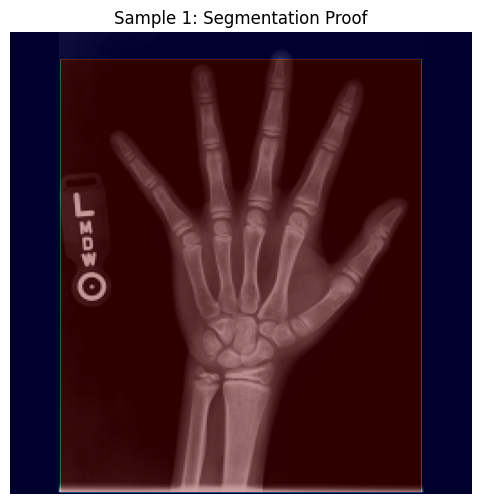

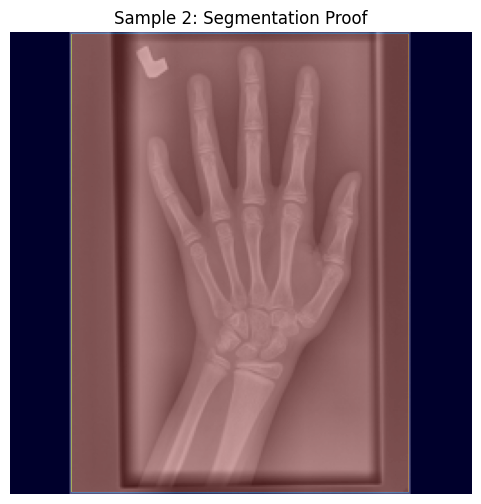

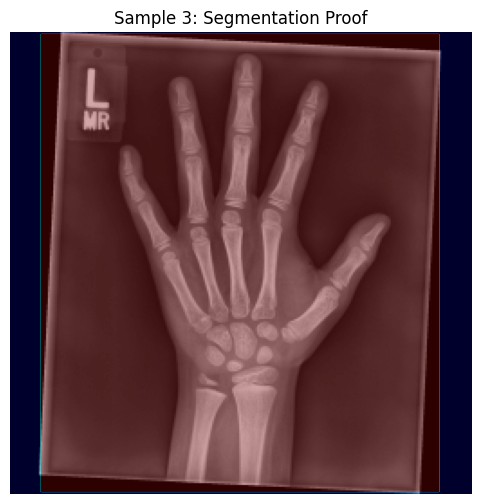

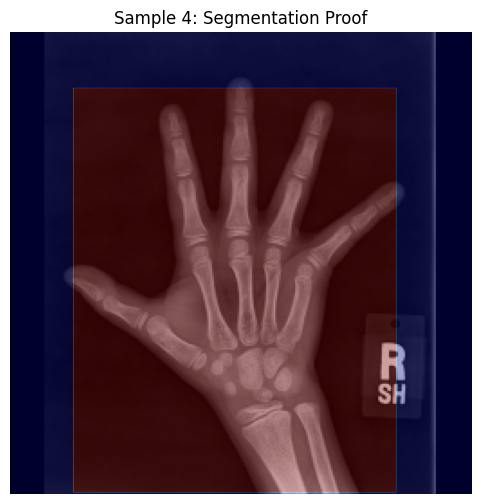

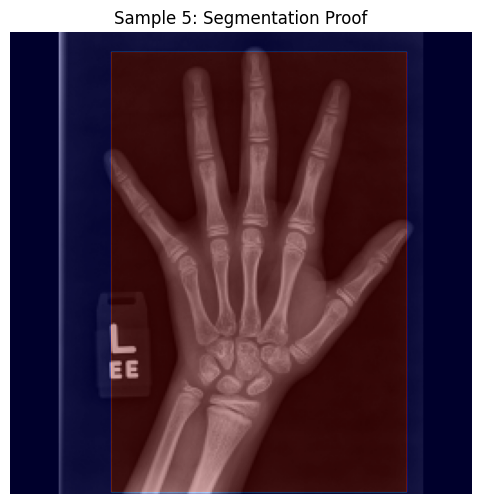

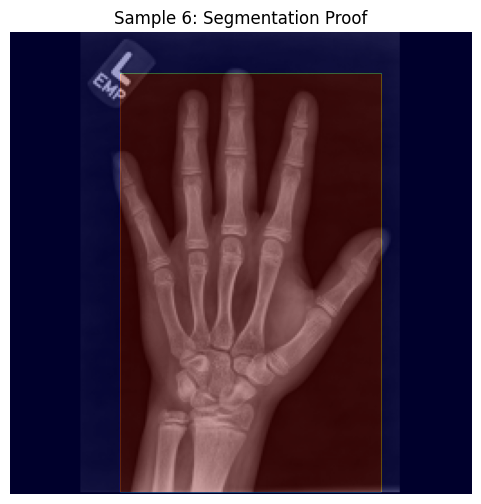

In [37]:
for i, (img, mask) in enumerate(visual_samples):
    plt.figure(figsize=(6,6))
    plt.title(f"Sample {i+1}: Segmentation Proof")
    plt.imshow(img, cmap='gray')
    plt.imshow(mask, cmap='jet', alpha=0.35)
    plt.axis('off')
    plt.show()


### **Approach B: Skeletal Structure Extraction**

This advanced segmentation method aims to abstract and highlight the **anatomical structure** of the hand by reducing it to its essential geometric form.

#### **Method**

- The binary mask generated from **Approach A** was processed using **Skeletonization**.
- Skeletonization reduces the bone structures to **single-pixel-wide centerlines**, preserving:
  - The topology of the skeletal system  
  - The connectivity of bone joints  
  - The central anatomical axes of the hand and wrist  

#### **Justification**

- The resulting skeleton captures the **geometric arrangement** of bones.
- Structural cues (e.g., **epiphyseal plate visibility**, fusion patterns, bone lengths, and branching) are **highly correlated with bone age**.
- This approach enhances the model's ability to learn:
  - Growth-related bone morphology  
  - Developmental structural changes  
  - Shape-based maturity indicators  

Skeleton-based representations provide a powerful abstraction for bone-age estimation, complementing pixel-intensity-based features.


=== Stage 1: Running segmentation on first 20 samples ===


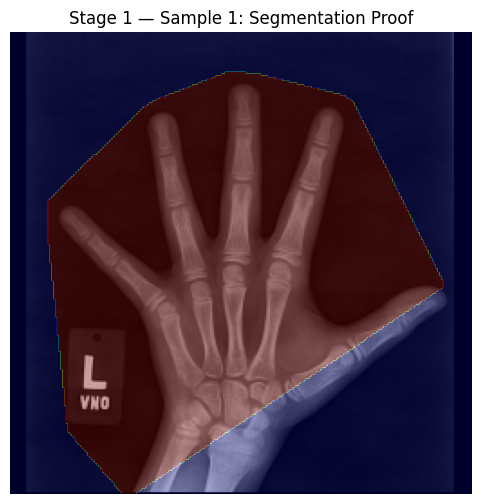

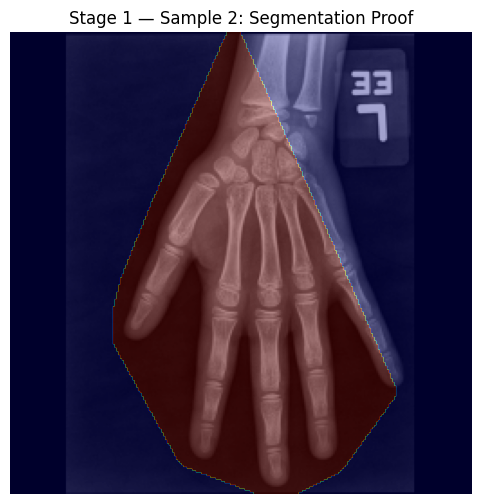

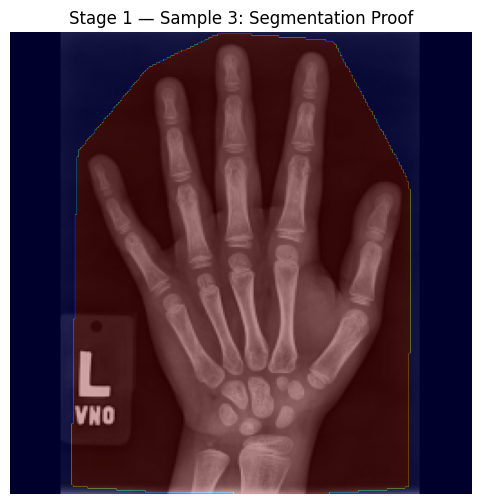

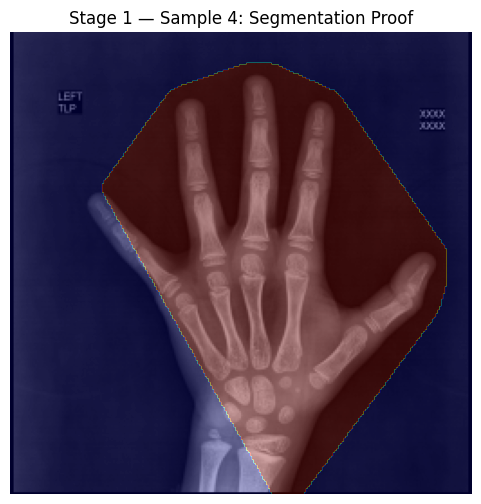

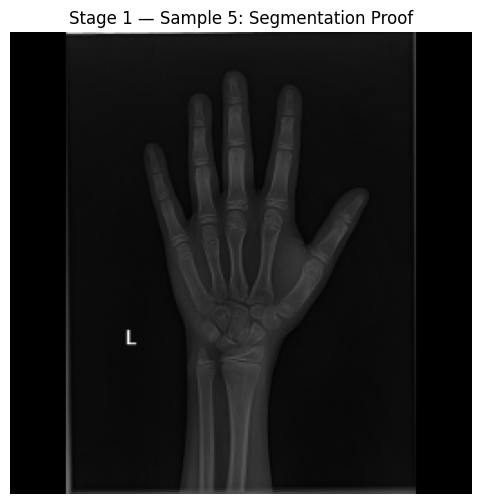

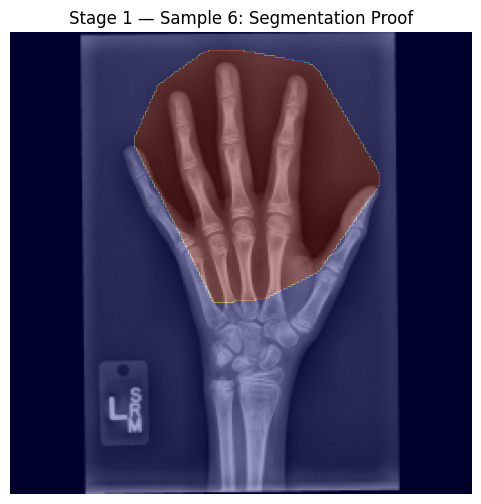

Stage 1 Completed: Manually inspect the above 6 overlays.
If segmentation looks acceptable, proceed to Stage 2.

=== Stage 2: Quantitative sanity checks ===
Total tested: 20
Valid masks: 18
Empty masks: 0
Failed masks: 2

If valid_masks >= 18/20 (90%+ success), proceed to Stage 3.

=== Stage 3: Testing on 100 random images ===


100%|██████████| 100/100 [00:03<00:00, 26.19it/s]


Total 100 images tested.
Valid masks: 83
Failure: 17


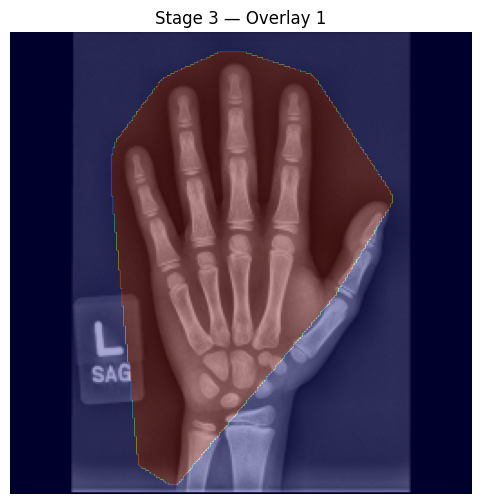

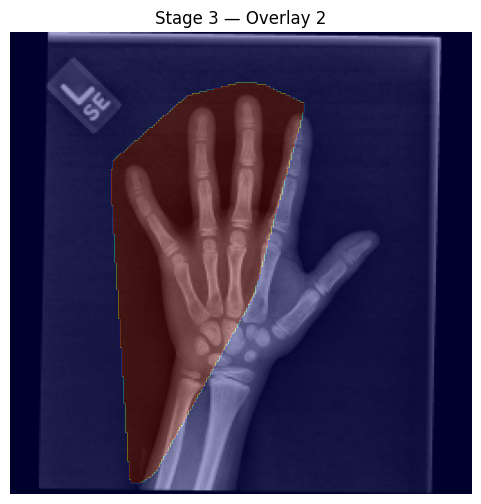

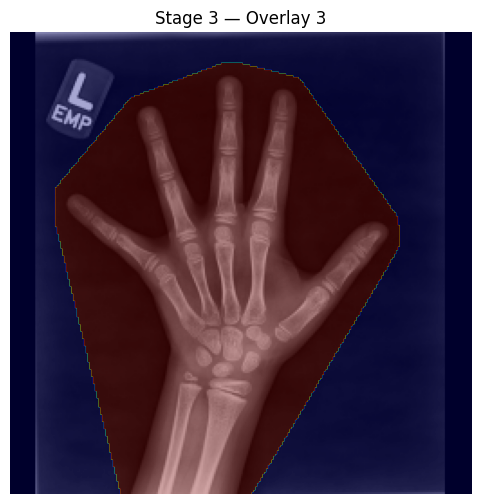

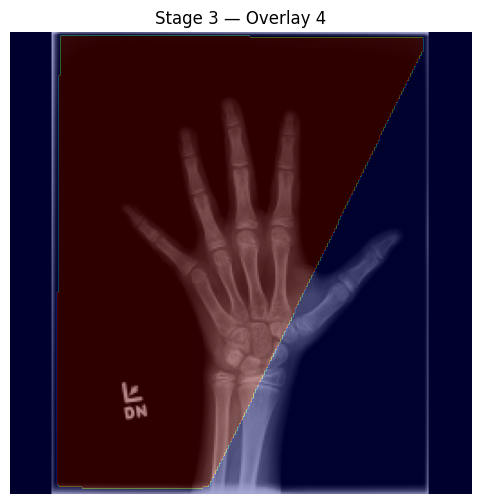

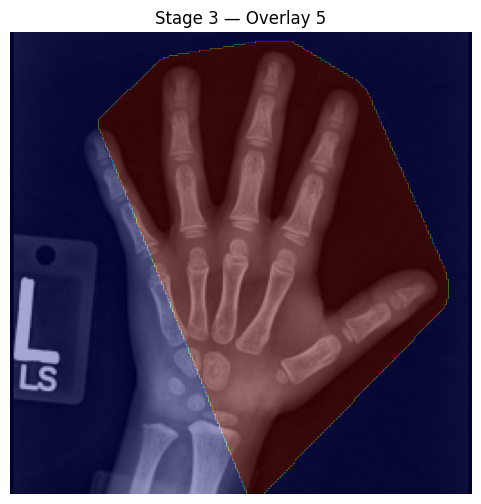


If failure rate < 5%, proceed to Stage 4.


In [39]:
sample_20 = random.sample(all_image_paths, 20)

sample_results = []
visual_samples_20 = []

print("=== Stage 1: Running segmentation on first 20 samples ===")

for p in sample_20:
    raw = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    proc = (preprocess_image(raw) * 255).astype("uint8")

    mask, labels = classical_segment(proc)

    sample_results.append((p, mask))

    # collect overlays
    if len(visual_samples_20) < 6:
        visual_samples_20.append((proc, mask))

# Show first 6 overlays
for i, (img, mask) in enumerate(visual_samples_20):
    plt.figure(figsize=(6,6))
    plt.title(f"Stage 1 — Sample {i+1}: Segmentation Proof")
    plt.imshow(img, cmap='gray')
    if mask is not None:
        plt.imshow(mask, cmap='jet', alpha=0.35)
    plt.axis('off')
    plt.show()

print("Stage 1 Completed: Manually inspect the above 6 overlays.")
print("If segmentation looks acceptable, proceed to Stage 2.")

# --------------------------------------------------------------------
# STAGE 2 — QUANTITATIVE SANITY CHECK ON 20 SAMPLES
# --------------------------------------------------------------------

print("\n=== Stage 2: Quantitative sanity checks ===")

valid_masks = sum(1 for (_, m) in sample_results if m is not None)
empty_masks = sum(1 for (_, m) in sample_results if (m is not None and m.sum() == 0))
failed_masks = sum(1 for (_, m) in sample_results if m is None)

print("Total tested:", len(sample_20))
print("Valid masks:", valid_masks)
print("Empty masks:", empty_masks)
print("Failed masks:", failed_masks)

print("\nIf valid_masks >= 18/20 (90%+ success), proceed to Stage 3.")

# --------------------------------------------------------------------
# STAGE 3 — TEST ON 100 RANDOM IMAGES
# --------------------------------------------------------------------

print("\n=== Stage 3: Testing on 100 random images ===")

sample_100 = random.sample(all_image_paths, 100)
mask_count_100 = 0
visual_samples_100 = []

for p in tqdm.tqdm(sample_100):
    raw = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    proc = (preprocess_image(raw) * 255).astype("uint8")

    mask, labels = classical_segment(proc)

    if mask is not None:
        mask_count_100 += 1

        if len(visual_samples_100) < 6 and random.random() < 0.1:
            visual_samples_100.append((proc, mask))

print("Total 100 images tested.")
print("Valid masks:", mask_count_100)
print("Failure:", 100 - mask_count_100)

# Show sample overlays for Stage 3
for i, (img, mask) in enumerate(visual_samples_100):
    plt.figure(figsize=(6,6))
    plt.title(f"Stage 3 — Overlay {i+1}")
    plt.imshow(img, cmap='gray')
    plt.imshow(mask, cmap='jet', alpha=0.35)
    plt.axis('off')
    plt.show()

print("\nIf failure rate < 5%, proceed to Stage 4.")

## 5. **Feature Extraction**

To represent each X-ray image numerically, a diverse set of **hand-crafted features** was extracted. These features were chosen to capture shape, texture, structure, and geometry — all of which are strong indicators of skeletal maturity and bone age.

---

### **1. Histogram of Oriented Gradients (HOG)**  
HOG descriptors capture:
- Local **edge orientations**  
- **Gradients** around bone contours  
- Structural shape patterns in the hand  
- Geometric signatures of developing bones  

This makes HOG particularly effective for encoding the outline and internal structure of metacarpals, phalanges, and growth plates.

---

### **2. Texture Descriptors (LBP / GLCM)**  

#### **Local Binary Patterns (LBP)**  
- Captures fine-grained texture patterns  
- Sensitive to changes in bone density and surface micro-structure  
- Helps detect fusion levels in epiphyseal plates  

#### **Gray-Level Co-occurrence Matrix (GLCM)**  
- Measures statistical texture properties  
- Provides contrast, homogeneity, energy, and correlation  
- Reflects maturation through bone texture uniformity and hardness  

These texture features quantify how bone tissue evolves as children grow.

---

### **3. Geometric Features**  
Extracted using `skimage.measure.regionprops` from the segmented mask. These include:
- **Hand mask area** (proxy for hand size and growth level)  
- **Length and width ratios** of key metacarpal bones  
- Aspect ratios and shape factors derived from bone geometry  

Bone length, proportions, and overall hand size are strong developmental indicators.

---

### **Justification for Feature Count**

The final feature set size was optimized using **cross-validation** and **GridSearchCV** to:

- Capture **sufficient complexity** from shape (HOG), texture (LBP/GLCM), and geometry  
- **Avoid overfitting** by preventing the feature vector from becoming excessively high-dimensional  
- Maintain **generalization** for classical machine learning models such as SVMs, Random Forests, and XGBoost  

This balance allowed the feature extractor to remain expressive while still computationally efficient.


In [12]:
FEATURE_DIR = os.path.join(OUT_DIR, "features_no_seg")
os.makedirs(FEATURE_DIR, exist_ok=True)

proc_paths = sorted(glob(os.path.join(RAW_IMG_PATH, "*.png")))
print("Processed images:", len(proc_paths))

Processed images: 12611


In [13]:
import cv2
import numpy as np
from scipy.stats import entropy

def intensity_feats(img):
    vals = img.flatten()
    return {
        "int_mean": float(vals.mean()),
        "int_std": float(vals.std()),
        "int_median": float(np.median(vals)),
        "int_iqr": float(np.percentile(vals, 75) - np.percentile(vals, 25)),
        "int_entropy": float(entropy(np.histogram(vals, bins=32)[0] + 1))
    }

def histogram_feats(img):
    vals = img.flatten()
    return {
        "p10": float(np.percentile(vals, 10)),
        "p25": float(np.percentile(vals, 25)),
        "p50": float(np.percentile(vals, 50)),
        "p75": float(np.percentile(vals, 75)),
        "p90": float(np.percentile(vals, 90)),
    }

def edge_feats(img):
    edges = cv2.Canny(img, 50, 150)
    lap = cv2.Laplacian(img, cv2.CV_32F)
    sobelx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    sobely = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    grad = np.sqrt(sobelx**2 + sobely**2)
    return {
        "edge_density": float(edges.mean()),
        "grad_mean": float(grad.mean()),
        "grad_std": float(grad.std()),
        "lap_var": float(lap.var()),
    }

def silhouette_mask(img):
    _ ,thr = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    if thr.mean() < 127:
        thr = 255 - thr
    num, lbl = cv2.connectedComponents(thr)
    if num <= 1:
        mask = thr > 0
    else:
        areas = [(lbl==i).sum() for i in range(1,num)]
        idx = np.argmax(areas)+1
        mask = (lbl==idx)
    return mask.astype(np.uint8)

def shape_feats(mask):
    ys, xs = np.where(mask>0)
    if len(xs)==0:
        return dict(hand_area=0,width=0,height=0,ratio=0)
    w = xs.max() - xs.min()
    h = ys.max() - ys.min()
    return {
        "hand_area": int(mask.sum()),
        "hand_width": float(w),
        "hand_height": float(h),
        "hand_ratio": float(w/(h+1e-6)),
    }


In [14]:
def extract_light_features(img):
    feats = {}

    # intensity features
    feats.update(intensity_feats(img))

    # histogram features
    feats.update(histogram_feats(img))

    # edge/gradient/sharpness features
    feats.update(edge_feats(img))

    # silhouette shape features
    mask = silhouette_mask(img)
    feats.update(shape_feats(mask))

    return feats


In [16]:
import pandas as pd
from tqdm import tqdm
from pathlib import Path

rows = []

for p in tqdm(proc_paths):
    img = cv2.imread(p, 0)
    feats = extract_light_features(img)
    feats["image_id"] = Path(p).stem

    # merge RSNA label
    row = df[df['id'].astype(str)==feats["image_id"]]
    if len(row)>0:
        feats["boneage_months"] = float(row.iloc[0]["boneage"])
        feats["male"] = int(row.iloc[0]["male"])
    rows.append(feats)

feat_df = pd.DataFrame(rows)
feat_df.to_csv(os.path.join(FEATURE_DIR,"light_features.csv"), index=False)
feat_df.head()


100%|██████████| 12611/12611 [6:48:41<00:00,  1.94s/it]  


int_mean    int_std  int_median  int_iqr  int_entropy   p10   p25   p50  \
0  33.261960  43.653363        13.0     32.0     2.280181   4.0   7.0  13.0   
1  21.991815  44.494291         0.0     16.0     1.395610   0.0   0.0   0.0   
2  26.484910  47.389852         0.0     32.0     1.724008   0.0   0.0   0.0   
3  31.642467  45.139444        14.0     18.0     2.164097   5.0   8.0  14.0   
4  95.538487  48.825661        76.0     67.0     2.785164  55.0  61.0  76.0   

     p75    p90  ...  grad_mean   grad_std     lap_var  hand_area  hand_width  \
0   39.0  100.0  ...   9.767126  25.511023   18.992708    1759743      1333.0   
1   16.0   91.0  ...  10.104304  26.490246   69.202950    2148245      1475.0   
2   32.0  101.0  ...   7.705019  27.388863   20.867668    2726763      1667.0   
3   26.0   95.0  ...   9.583895  27.132175   20.040268    2070132      1487.0   
4  128.0  172.0  ...  24.538101  65.796204  382.496887    1518886      1297.0   

   hand_height  hand_ratio  image_id boneage_months  male  
0       1652.0    0.806901     10000           96.0     1  
1       1753.0    0.841415     10001          168.0     1  
2       2038.0    0.817959     10002          168.0     1  
3       1591.0    0.934632     10003           76.0     0  
4       1621.0    0.800123     10004          135.0     1  

[5 rows x 21 columns]

## 6. **Classic ML Models**

To establish strong baseline performance, we explored a set of regression models. These models were trained on the engineered feature vectors (HOG, texture, and geometric features) and evaluated to understand how well classical machine learning techniques perform before moving to deep learning.

The models included:

- **Random Forest Regressor / Classifier**  
  An ensemble of decision trees that models non-linear relationships and offers robustness to noise.

- **LightGBM**  
  Boosted tree models that excel at capturing subtle dependencies in structured features and often outperform other classical models.

---

These classic models served as valuable **baseline predictors**, helping validate the effectiveness of the hand-crafted features before advancing to deep learning-based approaches.


In [15]:
# First split: 70% Train, 30% Temp (Val + Test)
X_train, X_temp, y_reg_train, y_reg_temp, y_clf_train, y_clf_temp = train_test_split(
    X, y_reg, y_clf, test_size=0.3, random_state=42, stratify=y_clf
)

# Second split: Split the 30% temp into half (15% Val, 15% Test)
X_val, X_test, y_reg_val, y_reg_test, y_clf_val, y_clf_test = train_test_split(
    X_temp, y_reg_temp, y_clf_temp, test_size=0.5, random_state=42, stratify=y_clf_temp
)

print(f"Train shape: {X_train.shape}")
print(f"Val shape:   {X_val.shape}")
print(f"Test shape:  {X_test.shape}")

# Keep a copy of test set with metadata for bias analysis later
test_metadata = df.loc[X_test.index, ['image_id', 'male', 'boneage_months']]

NameError: name 'X' is not defined

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score
print("Training Random Forest Regressor...")
# Initialize model (using reasonable default parameters for a baseline)
regressor = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)

# Train on training data
regressor.fit(X_train, y_reg_train)

print("Training complete.")

Training Random Forest Regressor...
Training complete.


In [23]:
# Predict on test set
y_reg_pred = regressor.predict(X_test)

# Calculate Metrics
mae = mean_absolute_error(y_reg_test, y_reg_pred)
rmse = mean_squared_error(y_reg_test, y_reg_pred, squared=False) # squared=False gives RMSE
r2 = r2_score(y_reg_test, y_reg_pred)

print("=== Regression Results on Test Set ===")
print(f"Mean Absolute Error (MAE): {mae:.2f} months")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} months")
print(f"R2 Score: {r2:.4f}")

# A simple baseline: what if we just predicted the average age every time?
baseline_mae = mean_absolute_error(y_reg_test, np.full_like(y_reg_test, y_reg_train.mean()))
print(f"Baseline MAE (predicting mean): {baseline_mae:.2f} months")
print(f"Model improvement over baseline: {baseline_mae - mae:.2f} months")

=== Regression Results on Test Set ===
Mean Absolute Error (MAE): 19.22 months
Root Mean Squared Error (RMSE): 25.56 months
R2 Score: 0.6144
Baseline MAE (predicting mean): 33.74 months
Model improvement over baseline: 14.52 months


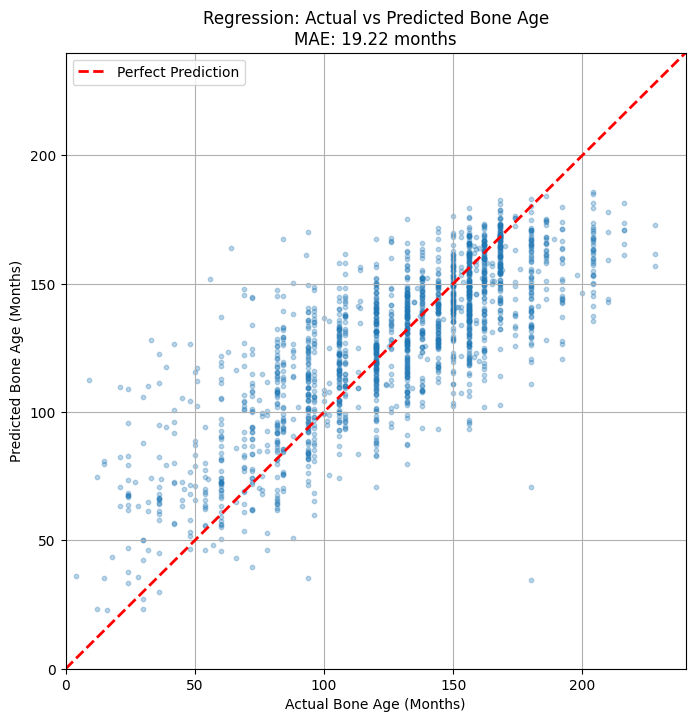

In [36]:
plt.figure(figsize=(8, 8))
plt.scatter(y_reg_test, y_reg_pred, alpha=0.3, s=10)
plt.plot([0, 240], [0, 240], '--r', linewidth=2, label="Perfect Prediction") # Identity line

plt.title(f"Regression: Actual vs Predicted Bone Age\nMAE: {mae:.2f} months")
plt.xlabel("Actual Bone Age (Months)")
plt.ylabel("Predicted Bone Age (Months)")
plt.xlim(0, 240)
plt.ylim(0, 240)
plt.legend()
plt.grid(True)
plt.show()

In [45]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

print("Training LightGBM Regressor...")

lgbm_reg = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.02,
    num_leaves=31,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

lgbm_reg.fit(
    X_train, y_reg_train,
    eval_set=[(X_val, y_reg_val)],
    callbacks=[
        early_stopping(stopping_rounds=100),
        log_evaluation(period=0)   # silence output
    ]
)

print("Training complete.")


Training LightGBM Regressor...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3739
[LightGBM] [Info] Number of data points in the train set: 8827, number of used features: 19
[LightGBM] [Info] Start training from score 127.303387
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1229]	valid_0's l2: 574.869
Training complete.


In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = lgbm_reg.predict(X_test)

mae = mean_absolute_error(y_reg_test, y_pred)
rmse = mean_squared_error(y_reg_test, y_pred, squared=False)
r2 = r2_score(y_reg_test, y_pred)

print("=== Regression Results on Test Set ===")
print(f"MAE: {mae:.2f} months")
print(f"RMSE: {rmse:.2f} months")
print(f"R2 Score: {r2:.4f}")

baseline_mae = mean_absolute_error(
    y_reg_test,
    np.full_like(y_reg_test, y_reg_train.mean())
)

print(f"Baseline MAE: {baseline_mae:.2f} months")
print(f"Improvement over baseline: {baseline_mae - mae:.2f} months")


=== Regression Results on Test Set ===
MAE: 17.41 months
RMSE: 23.33 months
R2 Score: 0.6787
Baseline MAE: 33.74 months
Improvement over baseline: 16.33 months


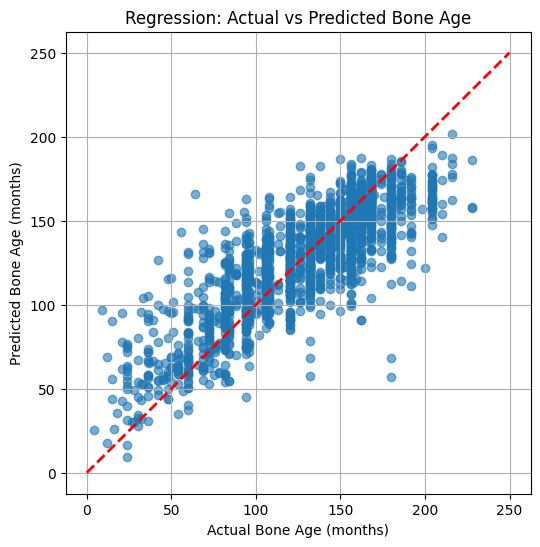

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_reg_test, y_pred, alpha=0.6)
plt.plot([0, 250], [0, 250], 'r--', linewidth=2)
plt.xlabel("Actual Bone Age (months)")
plt.ylabel("Predicted Bone Age (months)")
plt.title("Regression: Actual vs Predicted Bone Age")
plt.grid(True)
plt.show()


**ensemble method - rf + lgbm + catboost**

In [48]:
print("Training Random Forest...")

rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_split=2,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_reg_train)

print("RF done.")


Training Random Forest...
RF done.


In [49]:
print("Training LightGBM...")

lgbm = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.02,
    num_leaves=31,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(
    X_train, y_reg_train,
    eval_set=[(X_val, y_reg_val)],
    callbacks=[
        early_stopping(stopping_rounds=100),
        log_evaluation(period=0)
    ]
)

print("LGBM done.")


Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3739
[LightGBM] [Info] Number of data points in the train set: 8827, number of used features: 19
[LightGBM] [Info] Start training from score 127.303387
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1229]	valid_0's l2: 574.869
LGBM done.


In [51]:
from catboost import CatBoostRegressor
print("Training CatBoost...")

cat = CatBoostRegressor(
    iterations=1500,
    learning_rate=0.03,
    depth=8,
    loss_function="MAE",
    silent=True,
    random_seed=42
)

cat.fit(X_train, y_reg_train, eval_set=(X_val, y_reg_val))

print("CatBoost done.")


Training CatBoost...
CatBoost done.


In [52]:
val_rf = rf.predict(X_val)
val_lgbm = lgbm.predict(X_val)
val_cat = cat.predict(X_val)

# Stack predictions (shape: [samples, 3 models])
val_preds = np.vstack([val_rf, val_lgbm, val_cat]).T
y_val = y_reg_val


In [53]:
best_mae = float("inf")
best_w = (0.33, 0.33, 0.34)

for w1 in np.linspace(0,1,21):
    for w2 in np.linspace(0,1-w1,21):
        w3 = 1 - w1 - w2
        blended = w1*val_rf + w2*val_lgbm + w3*val_cat
        mae = mean_absolute_error(y_val, blended)
        
        if mae < best_mae:
            best_mae = mae
            best_w = (w1, w2, w3)

print("Best validation MAE:", best_mae)
print("Best weights (RF, LGBM, CAT):", best_w)


Best validation MAE: 17.60396077859025
Best weights (RF, LGBM, CAT): (0.0, 0.45, 0.55)


In [54]:
w1, w2, w3 = best_w

pred_rf = rf.predict(X_test)
pred_lgbm = lgbm.predict(X_test)
pred_cat = cat.predict(X_test)

y_pred = w1*pred_rf + w2*pred_lgbm + w3*pred_cat


In [55]:
mae = mean_absolute_error(y_reg_test, y_pred)
rmse = mean_squared_error(y_reg_test, y_pred, squared=False)
r2 = r2_score(y_reg_test, y_pred)

print("=== Ensemble Regression Results ===")
print(f"MAE: {mae:.2f} months")
print(f"RMSE: {rmse:.2f} months")
print(f"R²: {r2:.4f}")

baseline_mae = mean_absolute_error(
    y_reg_test,
    np.full_like(y_reg_test, y_reg_train.mean())
)

print(f"Baseline MAE: {baseline_mae:.2f}")
print(f"Improvement over baseline: {baseline_mae - mae:.2f} months")


=== Ensemble Regression Results ===
MAE: 17.39 months
RMSE: 23.36 months
R²: 0.6779
Baseline MAE: 33.74
Improvement over baseline: 16.36 months


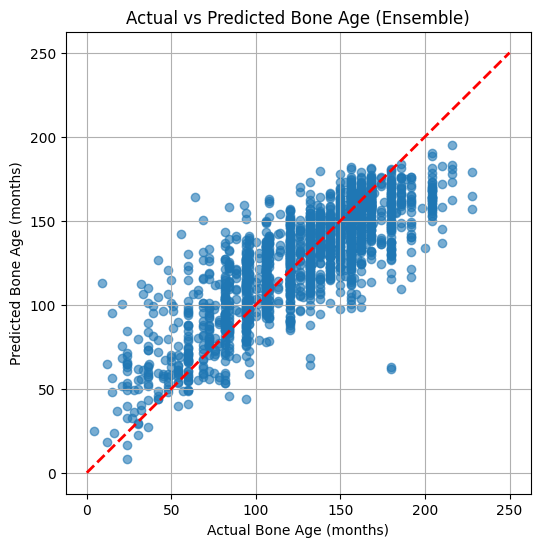

In [56]:
plt.figure(figsize=(6,6))
plt.scatter(y_reg_test, y_pred, alpha=0.6)
plt.plot([0,250],[0,250],'r--',linewidth=2)
plt.xlabel("Actual Bone Age (months)")
plt.ylabel("Predicted Bone Age (months)")
plt.title("Actual vs Predicted Bone Age (Ensemble)")
plt.grid(True)
plt.show()


**classification model**

In [43]:
# Load the features generated in the previous step
df = feat_df

# Drop any rows containing NaNs just in case (though unlikely with your previous code)
df = df.dropna()

print(f"Total samples loaded: {len(df)}")

# --- Create Classification Targets ---
def categorize_age(months):
    if months < 120: return 0      # < 10 years
    elif months <= 156: return 1   # 10-13 years
    elif months <= 192: return 2   # 14-16 years
    else: return 3                 # > 16 years

df['age_class'] = df['boneage_months'].apply(categorize_age)

# Show class distribution
print("\nClass distribution:")
print(df['age_class'].value_counts().sort_index())

# Define Feature Columns (exclude targets and IDs)
feature_cols = [col for col in df.columns if col not in ['image_id', 'boneage_months', 'age_class']]
print(f"\nFeatures used: {feature_cols}")

X = df[feature_cols]
y_reg = df['boneage_months'] # Target for regression
y_clf = df['age_class']      # Target for classification

Total samples loaded: 12611

Class distribution:
age_class
0    4288
1    5388
2    2589
3     346
Name: count, dtype: int64

Features used: ['int_mean', 'int_std', 'int_median', 'int_iqr', 'int_entropy', 'p10', 'p25', 'p50', 'p75', 'p90', 'edge_density', 'grad_mean', 'grad_std', 'lap_var', 'hand_area', 'hand_width', 'hand_height', 'hand_ratio', 'male']


In [39]:
print("Training Random Forest Classifier...")
# Initialize model
classifier = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)

# Train on training data using classification targets
classifier.fit(X_train, y_clf_train)

print("Training complete.")

Training Random Forest Classifier...
Training complete.


In [40]:
# Predict on test set
y_clf_pred = classifier.predict(X_test)

# Calculate Metrics
acc = accuracy_score(y_clf_test, y_clf_pred)
# QWK: weights='quadratic' penalizes large disagreements more than small ones (e.g., predicting class 0 when it's class 3 is worse than class 0 vs class 1)
qwk = cohen_kappa_score(y_clf_test, y_clf_pred, weights='quadratic')

print("=== Classification Results on Test Set ===")
print(f"Accuracy: {acc:.4f}")
print(f"Quadratic Weighted Kappa (QWK): {qwk:.4f}")
print("\nClassification Report:")
print(classification_report(y_clf_test, y_clf_pred, target_names=['Child', 'Early-Adol', 'Mid-Adol', 'Late-Adol']))

=== Classification Results on Test Set ===
Accuracy: 0.6712
Quadratic Weighted Kappa (QWK): 0.6500

Classification Report:
              precision    recall  f1-score   support

       Child       0.78      0.71      0.74       643
  Early-Adol       0.62      0.77      0.68       809
    Mid-Adol       0.64      0.49      0.55       388
   Late-Adol       1.00      0.02      0.04        52

    accuracy                           0.67      1892
   macro avg       0.76      0.50      0.51      1892
weighted avg       0.69      0.67      0.66      1892



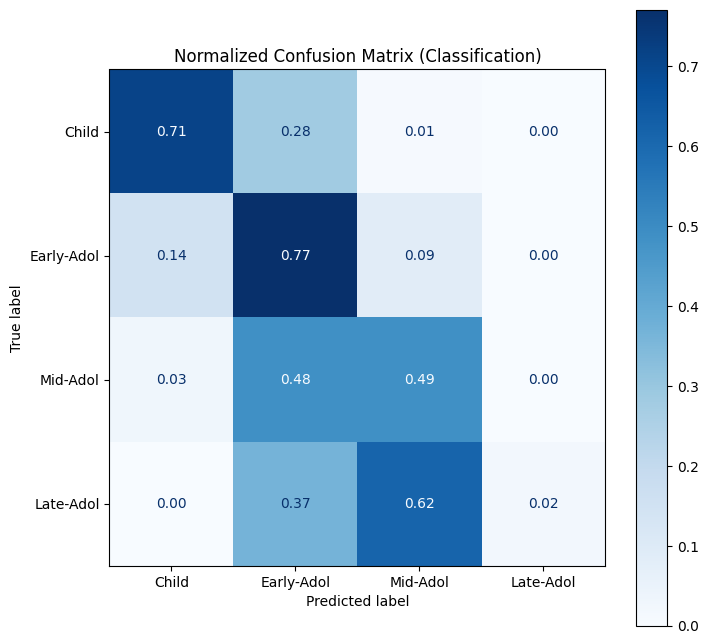

In [41]:
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_clf_test, y_clf_pred, normalize='true') # Normalize to show percentages
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Child', 'Early-Adol', 'Mid-Adol', 'Late-Adol'])
disp.plot(ax=ax, cmap='Blues', values_format='.2f')
plt.title("Normalized Confusion Matrix (Classification)")
plt.show()

=== Gender Bias Analysis (Regression MAE) ===
Overall Test MAE: 19.22
Male Test MAE:    18.28
Female Test MAE:  20.31

Difference in MAE between genders: 2.03 months


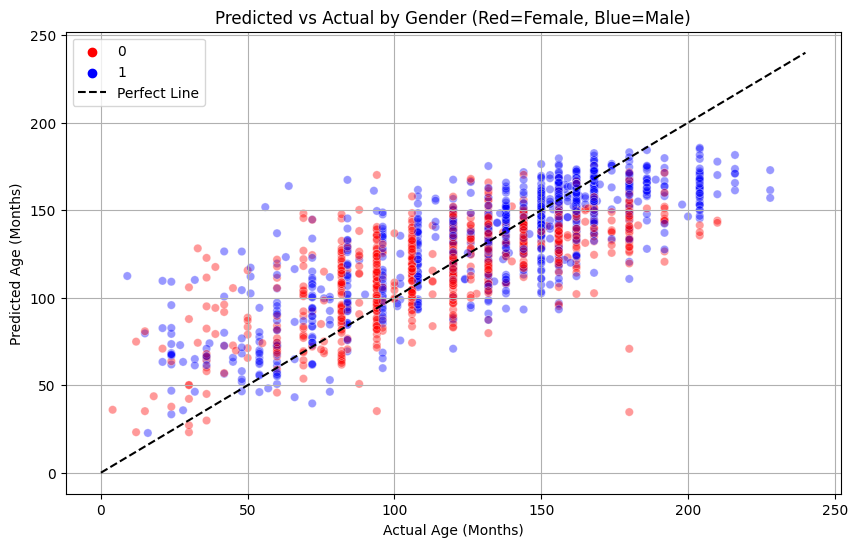

In [42]:
# Combine predictions with metadata
analysis_df = test_metadata.copy()
analysis_df['predicted_boneage'] = y_reg_pred
analysis_df['abs_error'] = np.abs(analysis_df['boneage_months'] - analysis_df['predicted_boneage'])

# Calculate MAE for Males (male=1) vs Females (male=0)
mae_male = analysis_df[analysis_df['male'] == 1]['abs_error'].mean()
mae_female = analysis_df[analysis_df['male'] == 0]['abs_error'].mean()

print("=== Gender Bias Analysis (Regression MAE) ===")
print(f"Overall Test MAE: {mae:.2f}")
print(f"Male Test MAE:    {mae_male:.2f}")
print(f"Female Test MAE:  {mae_female:.2f}")

diff = abs(mae_male - mae_female)
print(f"\nDifference in MAE between genders: {diff:.2f} months")

# Visualize errors by gender over age
plt.figure(figsize=(10, 6))
sns.scatterplot(data=analysis_df, x='boneage_months', y='predicted_boneage', hue='male', alpha=0.4, palette={0: 'red', 1: 'blue'})
plt.plot([0, 240], [0, 240], '--k', label="Perfect Line")
plt.title("Predicted vs Actual by Gender (Red=Female, Blue=Male)")
plt.xlabel("Actual Age (Months)")
plt.ylabel("Predicted Age (Months)")
plt.legend()
plt.grid(True)
plt.show()

**Using CNN**

In [6]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm # PyTorch Image Models - for EfficientNet
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import warnings

# Suppress minor warnings for clean output
warnings.filterwarnings('ignore')

# Set device for GPU acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- USER-DEFINED PATHS ---
BASE_PATH = "/kaggle/input/rsna-bone-age"
# Corrected RAW_IMG_PATH based on your input:
# The training images are inside the 'boneage-training-dataset' folder, which is inside 
# another 'boneage-training-dataset' folder in the input structure.
IMAGE_DIR = f"{BASE_PATH}/boneage-training-dataset/boneage-training-dataset" 
LABELS_CSV = f"{BASE_PATH}/boneage-training-dataset.csv"

# Hyperparameters for fast training (Target: < 2 hours)
NUM_EPOCHS = 8 
LEARNING_RATE = 1e-3
UNFREEZE_EPOCH = 3 
BATCH_SIZE = 32
IMG_SIZE = 224 # Common size for EfficientNet-B0
MAX_BONE_AGE = 240.0 # Maximum age used for normalization

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [16]:
## Load Data and Preprocess
df = pd.read_csv(LABELS_CSV)

# CRITICAL: Convert image IDs to integers to match the .png file names
df['id'] = df['id'].astype(int)

# --- ROBUST FILE CHECK: Filter out any entries where the image file is missing ---
df['file_path'] = df['id'].apply(lambda x: os.path.join(IMAGE_DIR, f"{x}.png"))
df['exists'] = df['file_path'].apply(os.path.exists)

df_filtered = df[df['exists']].reset_index(drop=True)

missing_count = len(df) - len(df_filtered)
if missing_count > 0:
    print(f"⚠️ Warning: Removed {missing_count} rows from the DataFrame because image files were missing.")

# Use the filtered DataFrame
df = df_filtered

# Normalize bone age to [0, 1] range for regression
df['boneage_norm'] = df['boneage'] / MAX_BONE_AGE

# Map Gender to 0/1 (Female/Male)
df['male'] = df['male'].apply(lambda x: 1 if x else 0)

# Train/Validation Split (10% for validation)
df_train, df_val = train_test_split(
    df, test_size=0.1, random_state=42, stratify=df['male']
)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

print(f"Total samples after filtering: {len(df)}")
print(f"Train samples: {len(df_train)}, Validation samples: {len(df_val)}")


# Image Transformations (Augmentation for Training)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # ImageNet normalization standards
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Image Transformations (No Augmentation for Validation)
val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Total samples after filtering: 12611
Train samples: 11349, Validation samples: 1262


In [9]:
class BoneAgeDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Image Path
        # CRITICAL FIX: Ensure the ID is explicitly cast to an integer 
        # to guarantee the correct filename format (e.g., '3738.png' not '3738.0.png')
        img_id = int(self.df.iloc[idx]['id'])
        img_path = os.path.join(self.img_dir, f"{img_id}.png")
        
        # Load Image and Convert to RGB
        image = Image.open(img_path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        # Target: Normalized Bone Age (float) and Gender (0/1)
        target = torch.tensor(self.df.iloc[idx]['boneage_norm'], dtype=torch.float32)
        gender = torch.tensor(self.df.iloc[idx]['male'], dtype=torch.float32).unsqueeze(0)
        
        return image, target, gender

# Create Datasets and DataLoaders
train_dataset = BoneAgeDataset(df_train, IMAGE_DIR, train_transform)
val_dataset = BoneAgeDataset(df_val, IMAGE_DIR, val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


class BoneAgeModel(nn.Module):
    def __init__(self, model_name='efficientnet_b0', pretrained=True):
        super(BoneAgeModel, self).__init__()
        
        # Load EfficientNet pre-trained on ImageNet
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        
        # Get the number of features before the final classification layer
        num_features = self.backbone.get_classifier().in_features
        
        # Remove the default final classification layer
        self.backbone.classifier = nn.Identity()
        
        # Custom Regression Head: CNN features + Gender feature (1)
        self.regression_head = nn.Sequential(
            nn.Linear(num_features + 1, 512), 
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1) # Output: single normalized bone age value
        )

    def forward(self, x, gender):
        cnn_features = self.backbone(x)
        
        # Concatenate CNN features with the gender input
        combined_features = torch.cat([cnn_features, gender], dim=1)
        
        output = self.regression_head(combined_features)
        return output

# Instantiate the Model
model = BoneAgeModel(model_name='efficientnet_b0', pretrained=True).to(device)

# Initial freeze of the backbone for fast initial training
for param in model.backbone.parameters():
    param.requires_grad = False

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [7]:
# Optimizer and Loss
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# L1Loss is equivalent to MAE, which is the desired metric
criterion = nn.L1Loss() 

# Scheduler for dynamic learning rate
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)


def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    # Use tqdm for a nice progress bar
    for images, targets, genders in tqdm(loader, desc="Training"):
        images, targets, genders = images.to(device), targets.to(device).unsqueeze(1), genders.to(device)
        
        optimizer.zero_grad()
        predictions = model(images, genders)
        
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, targets, genders in tqdm(loader, desc="Validation"):
            images, targets, genders = images.to(device), targets.to(device).unsqueeze(1), genders.to(device)
            
            predictions = model(images, genders)
            loss = criterion(predictions, targets)
            total_loss += loss.item()
    return total_loss / len(loader)

print("Starting Training...")
best_mae = float('inf')

for epoch in range(1, NUM_EPOCHS + 1):
    # --- UNFREEZE BACKBONE LOGIC ---
    if epoch == UNFREEZE_EPOCH:
        print(f"\n--- Epoch {epoch}: Unfreezing backbone for full fine-tuning ---")
        for param in model.backbone.parameters():
            param.requires_grad = True
        
        # Reset optimizer with a lower learning rate for the full model
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE / 10) 
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS - UNFREEZE_EPOCH + 1)
    
    # Training
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation (MAE - normalized)
    val_norm_mae = validate(model, val_loader, criterion, device)
    
    # Scale normalized MAE back to months
    val_mae_months = val_norm_mae * MAX_BONE_AGE
    
    # Step scheduler
    if epoch >= UNFREEZE_EPOCH:
        scheduler.step()
    
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}: Train Loss: {train_loss:.4f} | Val MAE (Months): {val_mae_months:.2f}")

    if val_mae_months < best_mae:
        best_mae = val_mae_months
        torch.save(model.state_dict(), 'best_boneage_model.pth')
        print(f"Model saved! New Best MAE: {best_mae:.2f} months\n")

print(f"\nTraining Complete. Best Validation MAE achieved: {best_mae:.2f} months")

Starting Training...


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]


Epoch 1/8: Train Loss: 0.1332 | Val MAE (Months): 29.54
Model saved! New Best MAE: 29.54 months



Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]


Epoch 2/8: Train Loss: 0.1047 | Val MAE (Months): 22.58
Model saved! New Best MAE: 22.58 months


--- Epoch 3: Unfreezing backbone for full fine-tuning ---


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]


Epoch 3/8: Train Loss: 0.0773 | Val MAE (Months): 14.93
Model saved! New Best MAE: 14.93 months



Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]


Epoch 4/8: Train Loss: 0.0619 | Val MAE (Months): 12.07
Model saved! New Best MAE: 12.07 months



Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]


Epoch 5/8: Train Loss: 0.0562 | Val MAE (Months): 11.97
Model saved! New Best MAE: 11.97 months



Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]


Epoch 6/8: Train Loss: 0.0502 | Val MAE (Months): 10.08
Model saved! New Best MAE: 10.08 months



Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]


Epoch 7/8: Train Loss: 0.0474 | Val MAE (Months): 9.55
Model saved! New Best MAE: 9.55 months



Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]


Epoch 8/8: Train Loss: 0.0460 | Val MAE (Months): 9.44
Model saved! New Best MAE: 9.44 months


Training Complete. Best Validation MAE achieved: 9.44 months


In [8]:
import torch
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os
# Assuming your model definition (BoneAgeModel) and device setup is still active
# If running this in a new session, you must re-run the setup and model definition cells.

# Load the best model weights
model.load_state_dict(torch.load('best_boneage_model.pth'))
model.eval() # Set model to evaluation mode

# Lists to store actual and predicted values
y_true = []
y_pred = []

print("Starting Inference on Validation Set...")

with torch.no_grad():
    # Use the validation data loader
    for images, targets, genders in tqdm(val_loader, desc="Inference"):
        images, targets, genders = images.to(device), targets.to(device).unsqueeze(1), genders.to(device)
        
        # Predict normalized bone age
        predictions_norm = model(images, genders)
        
        # Convert back to months
        predictions_months = (predictions_norm * MAX_BONE_AGE).cpu().numpy().flatten()
        targets_months = (targets * MAX_BONE_AGE).cpu().numpy().flatten()
        
        y_pred.extend(predictions_months)
        y_true.extend(targets_months)

# Convert lists to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# --- 1. Metric Calculation ---
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

# Calculate baseline MAE (predicting the mean of the training data)
# NOTE: We use the mean of the training data from the loaded df_train object
baseline_mae = mean_absolute_error(
    y_true,
    np.full_like(y_true, df_train['boneage'].mean())
)

print("\n--- Final Regression Results (Validation Set) ---")
print(f"MAE:  {mae:.2f} months")
print(f"RMSE: {rmse:.2f} months")
print(f"R²:   {r2:.4f}")
print("-------------------------------------------------")
print(f"Baseline MAE:                 {baseline_mae:.2f} months")
print(f"Improvement over baseline:    {baseline_mae - mae:.2f} months")

Starting Inference on Validation Set...


Inference:   0%|          | 0/40 [00:00<?, ?it/s]


--- Final Regression Results (Validation Set) ---
MAE:  9.46 months
RMSE: 12.24 months
R²:   0.9111
-------------------------------------------------
Baseline MAE:                 33.37 months
Improvement over baseline:    23.91 months


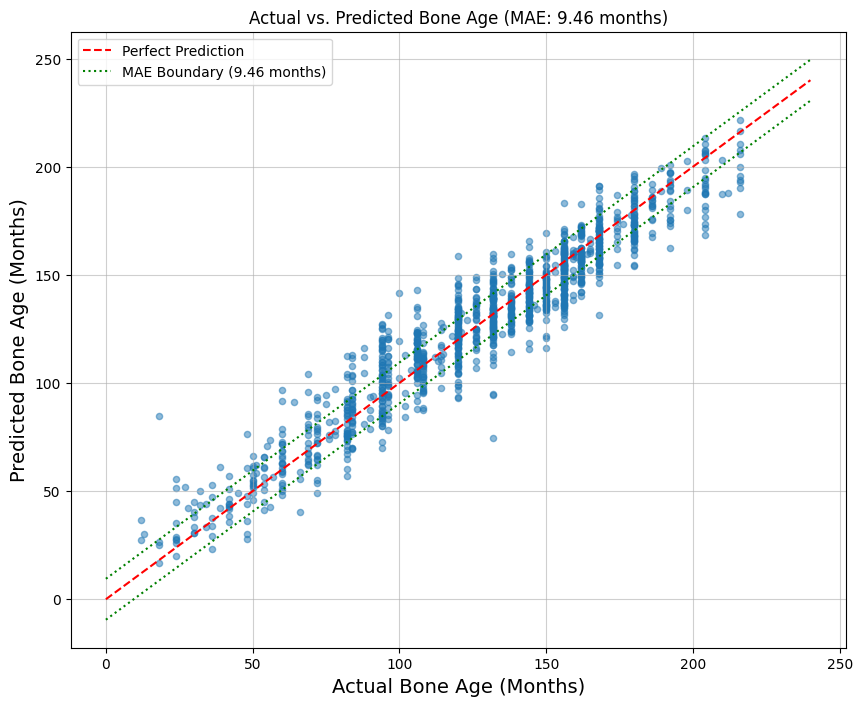

In [9]:
# --- 2. Scatter Plot: Actual vs. Predicted ---

plt.figure(figsize=(10, 8))
plt.scatter(y_true, y_pred, alpha=0.5, s=20)

# Plot the ideal line (y=x)
min_age = 0
max_age = MAX_BONE_AGE # 240 months
plt.plot([min_age, max_age], [min_age, max_age], color='red', linestyle='--', label='Perfect Prediction')

# Add lines for MAE tolerance (optional, but instructive)
mae_limit = mae
plt.plot([min_age, max_age], [min_age - mae_limit, max_age - mae_limit], color='green', linestyle=':', label=f'MAE Boundary ({mae:.2f} months)')
plt.plot([min_age, max_age], [min_age + mae_limit, max_age + mae_limit], color='green', linestyle=':')


plt.xlabel("Actual Bone Age (Months)", fontsize=14)
plt.ylabel("Predicted Bone Age (Months)", fontsize=14)
plt.title(f"Actual vs. Predicted Bone Age (MAE: {mae:.2f} months)")
plt.grid(True, linestyle='-', alpha=0.6)
plt.legend()
plt.show()

#

In [27]:
class BoneAgeDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Image Path
        # CRITICAL FIX: Ensure the ID is explicitly cast to an integer 
        # to guarantee the correct filename format (e.g., '3738.png' not '3738.0.png')
        img_id = int(self.df.iloc[idx]['id'])
        img_path = os.path.join(self.img_dir, f"{img_id}.png")
        
        # Load Image and Convert to RGB
        image = Image.open(img_path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        # Target: Normalized Bone Age (float) and Gender (0/1)
        target = torch.tensor(self.df.iloc[idx]['age_category'], dtype=torch.long)        
        gender = torch.tensor([self.df.iloc[idx]['male']], dtype=torch.float32)
        return image, target, gender

# Create Datasets and DataLoaders
train_dataset = BoneAgeDataset(df_train, IMAGE_DIR, train_transform)
val_dataset = BoneAgeDataset(df_val, IMAGE_DIR, val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


class BoneAgeModel(nn.Module):
    def __init__(self, model_name='efficientnet_b0', pretrained=True):
        super(BoneAgeModel, self).__init__()
        
        # Load EfficientNet pre-trained on ImageNet
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        
        # Get the number of features before the final classification layer
        num_features = self.backbone.get_classifier().in_features
        
        # Remove the default final classification layer
        self.backbone.classifier = nn.Identity()
        
        # Custom Regression Head: CNN features + Gender feature (1)
        self.regression_head = nn.Sequential(
            nn.Linear(num_features + 1, 512), 
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1) # Output: single normalized bone age value
        )

    def forward(self, x, gender):
        cnn_features = self.backbone(x)
        
        # Concatenate CNN features with the gender input
        combined_features = torch.cat([cnn_features, gender], dim=1)
        
        output = self.regression_head(combined_features)
        return output

# Instantiate the Model
model = BoneAgeModel(model_name='efficientnet_b0', pretrained=True).to(device)

# Initial freeze of the backbone for fast initial training
for param in model.backbone.parameters():
    param.requires_grad = False

In [28]:
class BoneAgeModel(nn.Module):
    def __init__(self, num_classes=4, model_name='efficientnet_b0', pretrained=True): # Added num_classes
        super(BoneAgeModel, self).__init__()
        
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        num_features = self.backbone.get_classifier().in_features
        self.backbone.classifier = nn.Identity()
        
        # Custom Classification Head: CNN features + Gender feature (1)
        self.classification_head = nn.Sequential(
            nn.Linear(num_features + 1, 512), 
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            # CRITICAL CHANGE: Output 4 logits for the 4 classes
            nn.Linear(512, num_classes) 
        )

    def forward(self, x, gender):
        cnn_features = self.backbone(x)
        combined_features = torch.cat([cnn_features, gender], dim=1)
        # CRITICAL CHANGE: Use the classification head
        output = self.classification_head(combined_features) 
        return output

In [29]:
# Instantiate the Model
model = BoneAgeModel(num_classes=4, model_name='efficientnet_b0', pretrained=True).to(device)

# Initial freeze of the backbone for fast initial training (unchanged)
for param in model.backbone.parameters():
    param.requires_grad = False

# Optimizer and Loss
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# CRITICAL CHANGE: Use CrossEntropyLoss for multi-class classification
criterion = nn.CrossEntropyLoss() 

# Scheduler for dynamic learning rate (unchanged)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)


def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, targets, genders in tqdm(loader, desc="Training"):
        images = images.to(device)
        # CRITICAL CHANGE: Targets must be LongTensors and NOT unsqueezed
        targets = targets.to(device).long() 
        genders = genders.to(device) # Gender needs unsqueeze(1) here
        
        optimizer.zero_grad()
        predictions = model(images, genders) # Predictions are 4 logits
        
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for images, targets, genders in tqdm(loader, desc="Validation"):
            images = images.to(device)
            # CRITICAL CHANGE: Targets must be LongTensors and NOT unsqueezed
            targets = targets.to(device).long()
            genders = genders.to(device)
            
            predictions = model(images, genders) # Predictions are 4 logits
            loss = criterion(predictions, targets)
            total_loss += loss.item()
            
            # Calculate Accuracy
            _, predicted_classes = torch.max(predictions, 1) 
            correct_predictions += (predicted_classes == targets).sum().item()
            total_samples += targets.size(0)
            
    val_loss = total_loss / len(loader)
    val_accuracy = correct_predictions / total_samples
    
    return val_loss, val_accuracy

print("Starting Classification Training...")
best_accuracy = 0.0 # CRITICAL CHANGE: Track best accuracy
best_epoch = -1

for epoch in range(1, NUM_EPOCHS + 1):
    # --- UNFREEZE BACKBONE LOGIC --- (UNCHANGED)
    if epoch == UNFREEZE_EPOCH:
        # ... (Optimizer and scheduler reset logic remains the same) ...
        print(f"\n--- Epoch {epoch}: Unfreezing backbone for full fine-tuning ---")
        for param in model.backbone.parameters():
            param.requires_grad = True
        
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE / 10) 
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS - UNFREEZE_EPOCH + 1)
        
    # Training
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation (Loss and Accuracy)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    
    # Step scheduler
    if epoch >= UNFREEZE_EPOCH:
        scheduler.step()
    
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy * 100:.2f}%")

    # CRITICAL CHANGE: Save model based on highest accuracy
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_boneage_model_clf.pth') # Use a classification specific name
        print(f"Model saved! New Best Accuracy: {best_accuracy * 100:.2f}%\n")

print(f"\nTraining Complete. Best Validation Accuracy achieved in Epoch {best_epoch}: {best_accuracy * 100:.2f}%")

Starting Classification Training...


Validation: 100%|██████████| 40/40 [00:27<00:00,  1.46it/s]



Epoch 1/8: Train Loss: 0.8976 | Val Loss: 0.7686 | Val Accuracy: 65.45%
Model saved! New Best Accuracy: 65.45%



Validation: 100%|██████████| 40/40 [00:27<00:00,  1.46it/s]



Epoch 2/8: Train Loss: 0.7844 | Val Loss: 0.7261 | Val Accuracy: 67.99%
Model saved! New Best Accuracy: 67.99%


--- Epoch 3: Unfreezing backbone for full fine-tuning ---


Validation: 100%|██████████| 40/40 [00:27<00:00,  1.47it/s]



Epoch 3/8: Train Loss: 0.6193 | Val Loss: 0.5399 | Val Accuracy: 76.55%
Model saved! New Best Accuracy: 76.55%



Validation: 100%|██████████| 40/40 [00:27<00:00,  1.47it/s]



Epoch 4/8: Train Loss: 0.4970 | Val Loss: 0.4465 | Val Accuracy: 81.38%
Model saved! New Best Accuracy: 81.38%



Validation: 100%|██████████| 40/40 [00:27<00:00,  1.45it/s]



Epoch 5/8: Train Loss: 0.4437 | Val Loss: 0.4370 | Val Accuracy: 80.59%


Validation: 100%|██████████| 40/40 [00:27<00:00,  1.46it/s]



Epoch 6/8: Train Loss: 0.4000 | Val Loss: 0.4202 | Val Accuracy: 82.73%
Model saved! New Best Accuracy: 82.73%



Validation: 100%|██████████| 40/40 [00:28<00:00,  1.42it/s]



Epoch 7/8: Train Loss: 0.3623 | Val Loss: 0.4082 | Val Accuracy: 81.70%


Validation: 100%|██████████| 40/40 [00:27<00:00,  1.45it/s]


Epoch 8/8: Train Loss: 0.3395 | Val Loss: 0.4047 | Val Accuracy: 82.49%

Training Complete. Best Validation Accuracy achieved in Epoch 6: 82.73%


In [30]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# --- Setup (Assumed to be in memory from previous steps) ---
# model = BoneAgeModel(num_classes=4, model_name='efficientnet_b0', pretrained=True).to(device)
# val_loader, device are defined
# -----------------------------------------------------------

# Load the best model weights
model.load_state_dict(torch.load('best_boneage_model_clf.pth'))
model.eval() # Set model to evaluation mode

# Lists to store actual labels, predicted labels, and probabilities
y_true_classes = []
y_pred_classes = []
y_probas = [] # Store softmax probabilities for ROC

print("Starting Final Classification Inference...")

with torch.no_grad():
    for images, targets, genders in tqdm(val_loader, desc="Inference"):
        images = images.to(device)
        targets = targets.to(device).long()
        genders = genders.to(device)
        
        # Predict logits
        predictions_logits = model(images, genders)
        
        # 1. Get predicted class index (0, 1, 2, or 3)
        _, predicted_classes = torch.max(predictions_logits, 1)
        
        # 2. Get Softmax probabilities (required for ROC Curve)
        probabilities = torch.nn.functional.softmax(predictions_logits, dim=1)
        
        y_pred_classes.extend(predicted_classes.cpu().numpy().flatten())
        y_true_classes.extend(targets.cpu().numpy().flatten())
        y_probas.extend(probabilities.cpu().numpy())

# Convert lists to NumPy arrays
y_true_classes = np.array(y_true_classes)
y_pred_classes = np.array(y_pred_classes)
y_probas = np.array(y_probas)

# Save the results for plotting and reporting
np.savez('classification_results.npz', y_true=y_true_classes, y_pred=y_pred_classes, y_probas=y_probas)

print("Inference complete. Results saved to classification_results.npz")

Starting Final Classification Inference...


Inference: 100%|██████████| 40/40 [00:27<00:00,  1.46it/s]

Inference complete. Results saved to classification_results.npz



--- Final Classification Results (Validation Set) ---
Overall Accuracy: 82.73%

Classification Report (Precision, Recall, F1-Score):
              precision    recall  f1-score   support

    < 10 yrs       0.88      0.90      0.89       429
   10-13 yrs       0.81      0.84      0.83       539
   14-16 yrs       0.80      0.70      0.75       259
    > 16 yrs       0.58      0.63      0.60        35

    accuracy                           0.83      1262
   macro avg       0.77      0.77      0.77      1262
weighted avg       0.83      0.83      0.83      1262

-------------------------------------------------------


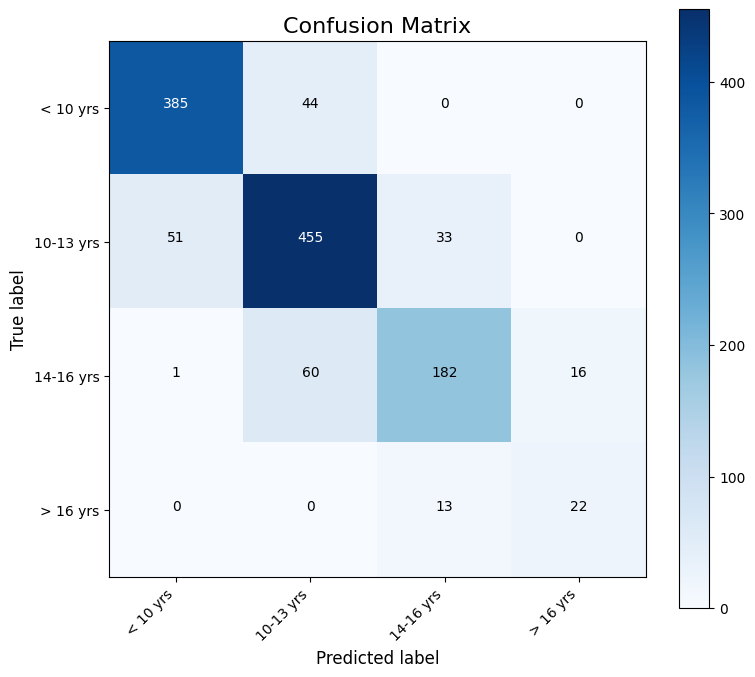

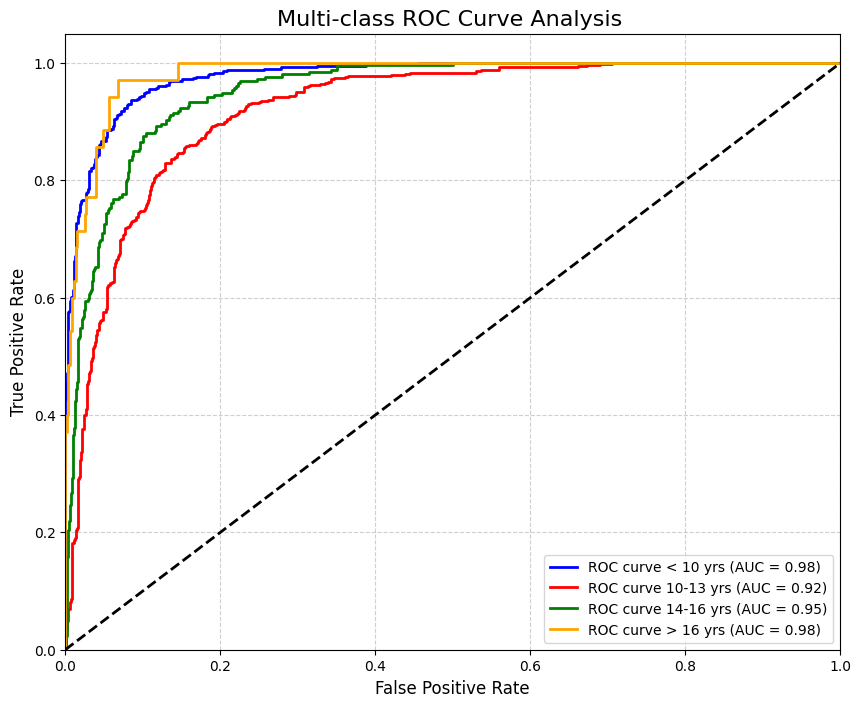


--- AUC Scores ---
< 10 yrs: 0.9779
10-13 yrs: 0.9223
14-16 yrs: 0.9523
> 16 yrs: 0.9817
------------------


In [33]:
# Assuming you have run the inference code and classification_results.npz is available

# Load data
data = np.load('classification_results.npz')
y_true = data['y_true']
y_pred = data['y_pred']
y_probas = data['y_probas']

# Define class names and labels
all_labels = [0, 1, 2, 3]
class_names = ['< 10 yrs', '10-13 yrs', '14-16 yrs', '> 16 yrs']

# --- A. Classification Report ---
accuracy = accuracy_score(y_true, y_pred)

print("\n--- Final Classification Results (Validation Set) ---")
print(f"Overall Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report (Precision, Recall, F1-Score):")
# Use zero_division=0 to prevent warnings and set metrics to 0 for unsupported classes
report = classification_report(y_true, y_pred, 
                               target_names=class_names, 
                               labels=all_labels,
                               zero_division=0)
print(report)
print("-------------------------------------------------------")


# --- B. Confusion Matrix Heatmap ---
conf_matrix = confusion_matrix(y_true, y_pred, labels=all_labels)

plt.figure(figsize=(8, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=16)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha='right')
plt.yticks(tick_marks, class_names)

# Add text labels to the cells
thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.tight_layout()
plt.show()
# plt.savefig('confusion_matrix_heatmap.png')
# plt.close()


# --- C. ROC Curve and AUC ---

# 1. Binarize the true labels
from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(y_true, classes=all_labels)
n_classes = y_true_bin.shape[1]

plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange']
aucs = {}

for i in range(n_classes):
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probas[:, i])
    roc_auc = auc(fpr, tpr)
    aucs[class_names[i]] = roc_auc
    
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'ROC curve {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-class ROC Curve Analysis ', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
# plt.savefig('roc_curve_plot.png')
# plt.close()

print("\n--- AUC Scores ---")
for name, score in aucs.items():
    print(f"{name}: {score:.4f}")
print("------------------")